## Importing needed modules

In [ ]:
!pip install idx2numpy
import numpy as np
import gzip
import matplotlib.pyplot as plt
import idx2numpy
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dowloading the dataset

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

sources = [
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz'
]

targets = [
    't10k-images.idx3-ubyte',
    't10k-labels.idx1-ubyte',
    'train-images.idx3-ubyte',
    'train-labels.idx1-ubyte'
]

for src, trg in zip(sources, targets):
  with gzip.open(src, 'rb') as f:
    file_content = f.read()
    with open(trg, "wb") as f_out:
      f_out.write(file_content)

!rm train-images-idx3-ubyte.gz
!rm train-labels-idx1-ubyte.gz
!rm t10k-images-idx3-ubyte.gz
!rm t10k-labels-idx1-ubyte.gz

--2023-04-25 15:45:34--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-04-25 15:45:35 (76.9 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-04-25 15:45:35--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

## Utility functions

In [240]:
'''
function that takes a list of lists as input and returns a flattened list
'''
def flatten(l):
  return [item for sublist in l for item in sublist]


'''
function that takes a tensor and add noise to that tensor
'''
def add_noise(x, std=0.01):
  eps = torch.randn(x.shape)*std
  eps = eps.to(device)
  return x+eps


'''
function used to load the data and return train-test images and labels
'''
def read_data(train_data_path='train-images.idx3-ubyte',
              train_label_path='train-labels.idx1-ubyte',
              test_data_path='t10k-images.idx3-ubyte',
              test_label_path='t10k-labels.idx1-ubyte'
              ):
  train_data = idx2numpy.convert_from_file(train_data_path)
  train_label = idx2numpy.convert_from_file(train_label_path)
  test_data = idx2numpy.convert_from_file(test_data_path)
  test_label = idx2numpy.convert_from_file(test_label_path)

  return train_data, train_label, test_data, test_label

'''
function that return the first n_images images of the required class 
'''
def get_images_from_class(data, labels, n_images, target):
  target_images = data[labels == target][:n_images]
  return torch.from_numpy(np.asarray(target_images)).float()


def visualize_reconstruction(model, data, labels, eps=0.1):

  loss_function = torch.nn.MSELoss()

  for target in range(0, 10):

    x = get_images_from_class(data, labels, 1, target)
    x = x.to(device)
    x_noisy = add_noise(x, eps)
    out, h = model(x_noisy.reshape(-1, 784))

    loss = loss_function(out, x.reshape(-1, 784))

    fig, ax = plt.subplots(1, 3, figsize=(6, 2))

    fig.suptitle(f"MSE: {round(loss.item(), 5)}", fontsize=12)
    fig.subplots_adjust(top=0.75)

    x = x.to("cpu")

    ax[0].imshow(x[0].cpu().detach().numpy(), cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Original")

    ax[1].imshow(x_noisy[0].cpu().detach().numpy(), cmap="Greys")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Noisy")

    ax[2].imshow(out[0].cpu().reshape(28, 28).detach().numpy(), cmap="Greys")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Reconstructed")

    plt.show()
    print("\n\n")


def test_interpolation_same_class(model, data, labels, alpha=0.5):

  loss_function = torch.nn.MSELoss()

  for target in range(0, 10):

    x = get_images_from_class(data, labels, 2, target)
    x = x.to(device)

    out, h = model(x.reshape(-1, 784))
    x_1, x_2 = x[0], x[1]
    z_1, z_2 = h[0], h[1]
    z = alpha*z_1 + (1-alpha)*z_2
    y = model.reconstruct(z)
    y = y.reshape(28, 28)

    fig, ax = plt.subplots(1, 3, figsize=(6, 2))

    # fig.suptitle(f"$alpha$: {round(loss.item(), 5)}", fontsize=12)

    ax[0].imshow(x_1.cpu().detach().numpy(), cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("First image")

    ax[1].imshow(x_2.cpu().detach().numpy(), cmap="Greys")
    ax[1].set_xticks([])
    ax[1].set_yticks([]) 
    ax[1].set_title("Second image")

    ax[2].imshow(y.cpu().detach().numpy(), cmap="Greys")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Interpolated")

    plt.show()
    print("\n\n")


def test_interpolation_different_classes(model, data, label, alpha=0.5):
  for target_1 in range(10):
    for target_2 in range(0, 10):

        x_1 = get_images_from_class(data, label, 1, target_1)[0]
        x_2 = get_images_from_class(data, label, 2, target_2)[0]

        x = torch.randn(2, 28, 28)
        x[0] = x_1
        x[1] = x_2

        x = x.to(device)

        out, h = model(x.reshape(-1, 784))
        z_1, z_2 = h[0], h[1]
        z = alpha*z_1 + (1-alpha)*z_2
        y = model.reconstruct(z)
        y = y.reshape(28, 28)

        fig, ax = plt.subplots(1, 3, figsize=(6, 2))

        ax[0].imshow(x_1.cpu().detach().numpy(), cmap="Greys")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("First image")

        ax[1].imshow(x_2.cpu().detach().numpy(), cmap="Greys")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("Second image")

        ax[2].imshow(y.cpu().detach().numpy(), cmap="Greys")
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_title("Interpolated")

        plt.show()
        print("\n\n")
        

def plot_learning_curves(train_losses, test_losses):
  plt.plot([x for x in range(1,len(train_losses)+1)], train_losses, label="Train")
  plt.plot([x for x in range(1,len(test_losses)+1)], test_losses, label="Test")
  plt.legend(loc="upper right")
  plt.show()


def test_interpolation_multiple_alpha_same_class(model, data, label):
  for target in range(0, 10):

    x = get_images_from_class(data, label, 2, target)
    x = x.to(device)
    out, h = model(x.reshape(-1, 784))
    x_1, x_2 = x[0], x[1]
    z_1, z_2 = h[0], h[1]
    fig, ax = plt.subplots(1, 10, figsize=(20, 5))

    for idx, alpha in enumerate([round(x*0.1,1) for x in range(1, 11)]):
      z = alpha*z_1 + (1-alpha)*z_2
      y = model.reconstruct(z)
      y = y.reshape(28, 28)
      ax[idx].imshow(y.detach().numpy(), cmap="Greys")
      ax[idx].set_xticks([])
      ax[idx].set_yticks([])
      ax[idx].set_title(fr"$\alpha = {alpha}$")



def test_interpolation_multiple_alpha_different_class(model, data, label):

  for target_1 in range(0, 10):
    for target_2 in range(0, 10):
      x_1 = get_images_from_class(data, label, 1, target_1)[0]
      x_2 = get_images_from_class(data, label, 2, target_2)[0]

      x = torch.randn(2, 28, 28)
      x[0] = x_1
      x[1] = x_2

      x = x.to(device)

      out, h = model(x.reshape(-1, 784))
      z_1, z_2 = h[0], h[1]
      fig, ax = plt.subplots(1, 10, figsize=(20, 5))

      for idx, alpha in enumerate([round(x*0.1,1) for x in range(1, 11)]):
        z = alpha*z_1 + (1-alpha)*z_2
        y = model.reconstruct(z)
        y = y.reshape(28, 28)
        ax[idx].imshow(y.detach().numpy(), cmap="Greys")
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].set_title(fr"$\alpha = {alpha}$")


## Load the dataset

In [ ]:
train_data, train_label, test_data, test_label = read_data()

train_data = train_data/255
test_data = test_data/255

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Defining the Dataset class

In [ ]:
class MNISTDataset(Dataset):
  
  def __init__(self, data, labels, transform=None):
    self.data = torch.from_numpy(np.asarray(data)).float()
    self.labels = torch.from_numpy(np.asarray(labels)).float()

    if len(self.data.shape) == 3:
      dim = self.data.shape[-1]
      self.data = self.data.reshape(-1, dim*dim)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

  def __len__(self):
    return self.data.shape[0]

## Define the class representing the Denoising Auto-Encoder class

In [ ]:
class DenoisingAutoEncoder(nn.Module):


  def __init__(self, layers):
    super(DenoisingAutoEncoder, self).__init__()
    encoder_modules = [[nn.Linear(layers[i], layers[i+1]), nn.ReLU()] for i in range(len(layers)-1)]
    decoder_modules = [[nn.Linear(layers[i], layers[i-1]), nn.ReLU() if i != 1 else nn.Sigmoid()] for i in reversed(range(1,len(layers)))]
    self.encoder = nn.ModuleList(flatten(encoder_modules))
    self.decoder = nn.ModuleList(flatten(decoder_modules))
    self.layers_size = layers


  def full_forward(self, x):
    for module in self.encoder:
      x = module(x)
    h = x
    for module in self.decoder:
      x = module(x)
    return x, h


  def layerwise_forward(self, x, n):
    for module in self.encoder[n*2:n*2+2]:
      x = module(x)
    h = x
    for module in self.decoder[len(self.decoder)-2*n-2:len(self.decoder)-2*n]:
      x = module(x)
    return x, h


  def forward(self, x, layer=None):
    return self.full_forward(x) if layer is None else self.layerwise_forward(x, layer)
    

  def freeze_layers(self, n):
    for module in self.encoder[n*2:n*2+2]:
      for param in module.parameters():
        param.require_grad = False 
    for module in self.decoder[len(self.decoder)-2*n-2:len(self.decoder)-2*n]:
      for param in module.parameters():
        param.require_grad = False 


  def get_labels(self, x, layer):
    for module in self.encoder[:2*layer]:
      x = module(x)
    return x


  def reconstruct(self, x):
    for module in self.decoder:
      x = module(x)
    return x


  def unfreeze_parameters(self):
    for module in self.encoder:
      for param in module.parameters():
        param.require_grad = True

    for module in self.decoder:
      for param in module.parameters():
        param.require_grad = True


In [ ]:
def train(model, epochs=10, layer=None):

  if layer is not None:
    print(f"Encoder to train:\n{model.encoder[layer*2:layer*2+2]}\nDecoder to train:\n{model.decoder[len(model.decoder)-2*layer-2:len(model.decoder)-2*layer]}\n")

  model = model.to(device)

  train_losses = []
  test_losses = []

  if layer is not None:
    with torch.no_grad():
      x_train = model.get_labels(torch.from_numpy(train_data).float().reshape(-1, 784), layer)
      x_test = model.get_labels(torch.from_numpy(test_data).float().reshape(-1, 784), layer)
      train_dataset = MNISTDataset(x_train.detach().numpy(), train_label)
      test_dataset = MNISTDataset(x_test.detach().numpy(), test_label)
  else:
    train_dataset = MNISTDataset(train_data, train_label)
    test_dataset = MNISTDataset(test_data, test_label)

  train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

  loss_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  model.train()

  for epoch in range(1,epochs+1):

    epoch_loss = 0
    pbar = tqdm(train_dataloader)

    for batch_id, (x, y) in enumerate(pbar):

      x = x.to(device)
      x_noisy = add_noise(x, 0.1)

      out, h = model(x_noisy, layer)

      loss = loss_function(x, out)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      pbar.set_description(f"Train loss: {loss.item()}")

    test_loss = 0
    pbar = tqdm(test_dataloader)
    model.eval()

    for batch_id, (x, y) in enumerate(pbar):

      x = x.to(device)
      out, h = model(x, layer)

      loss = loss_function(x, out)
      test_loss += loss.item()
      pbar.set_description(f"Test loss: {loss.item()}")


    epoch_loss /= len(train_dataloader)
    print(f"\nEpoch {epoch} train loss: {epoch_loss}")

    test_loss /= len(test_dataloader)
    print(f"Epoch {epoch} test loss: {test_loss}\n")

    train_losses.append(epoch_loss)
    test_losses.append(test_loss)

  return train_losses, test_losses


def test(model):

  test_dataset = MNISTDataset(test_data, test_label)
  test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

  loss_function = torch.nn.MSELoss()
  test_loss = 0
  model.eval()

  for batch_id, (x, y) in enumerate(test_dataloader):

    x = x.to(device)
    out, h = model(x)

    loss = loss_function(x, out)

    test_loss += loss.item()

  test_loss /= len(test_dataloader)
  print(f"Test loss: {test_loss}\n")

Test loss: 0.008991444483399391: 100%|██████████| 157/157 [00:03<00:00, 45.01it/s]



Epoch 1 train loss: 0.027715475779018804
Epoch 1 test loss: 0.009951020193517587



Test loss: 0.005294342525303364: 100%|██████████| 157/157 [00:01<00:00, 89.08it/s] 



Epoch 2 train loss: 0.007532055513548063
Epoch 2 test loss: 0.004897582792576141



Test loss: 0.0026841480284929276: 100%|██████████| 157/157 [00:01<00:00, 89.49it/s] 



Epoch 3 train loss: 0.00481492110209337
Epoch 3 test loss: 0.0034944251087749272



Test loss: 0.003101091366261244: 100%|██████████| 157/157 [00:01<00:00, 85.44it/s]



Epoch 4 train loss: 0.0038431550687385487
Epoch 4 test loss: 0.0028353505248832666



Test loss: 0.002612565876916051: 100%|██████████| 157/157 [00:03<00:00, 43.82it/s]



Epoch 5 train loss: 0.003369711494859634
Epoch 5 test loss: 0.002486132748223319



Test loss: 0.0017596753314137459: 100%|██████████| 157/157 [00:02<00:00, 52.86it/s]



Epoch 6 train loss: 0.00310744080982451
Epoch 6 test loss: 0.002257973310140193



Test loss: 0.0015877881087362766: 100%|██████████| 157/157 [00:01<00:00, 106.84it/s]



Epoch 7 train loss: 0.002951377121580721
Epoch 7 test loss: 0.0021650572870946993



Test loss: 0.0019469340331852436: 100%|██████████| 157/157 [00:02<00:00, 62.62it/s]



Epoch 8 train loss: 0.002847467886476613
Epoch 8 test loss: 0.002083831238352759



Test loss: 0.0014066745061427355: 100%|██████████| 157/157 [00:01<00:00, 103.51it/s]



Epoch 9 train loss: 0.0027789681656425124
Epoch 9 test loss: 0.0020023874017546417



Test loss: 0.0023137275129556656: 100%|██████████| 157/157 [00:01<00:00, 84.34it/s]



Epoch 10 train loss: 0.002724411475634985
Epoch 10 test loss: 0.0020139951801674953



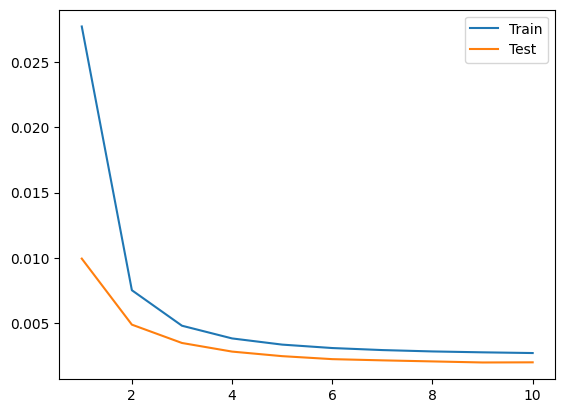

Test loss: 0.002014195637712196



In [ ]:
dae = DenoisingAutoEncoder([784, 128])
train_losses, test_losses = train(dae, 10)
plot_learning_curves(train_losses, test_losses)
test(dae)

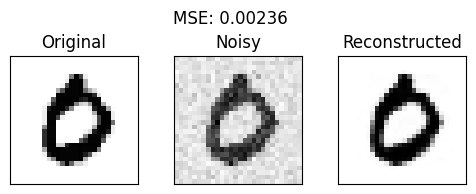

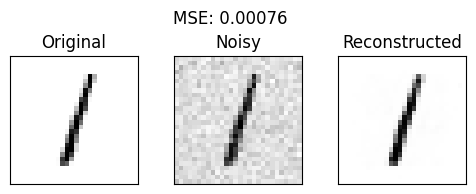

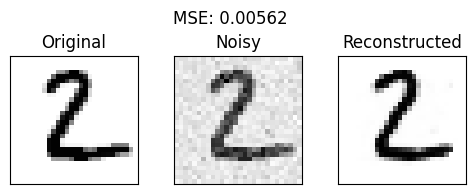

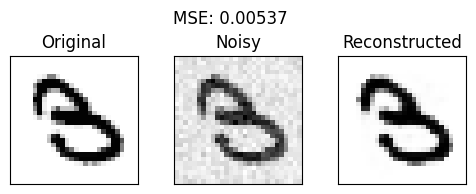

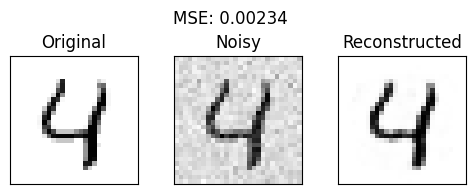

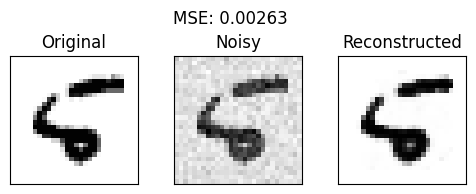

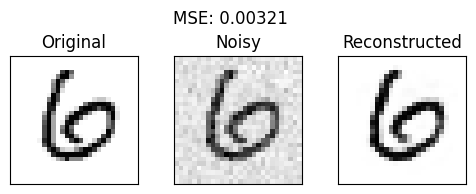

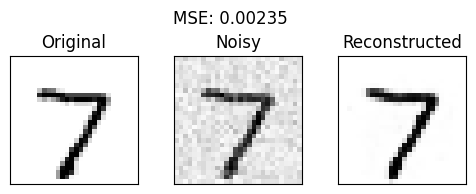

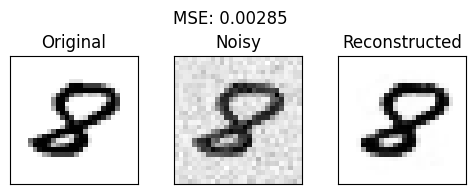

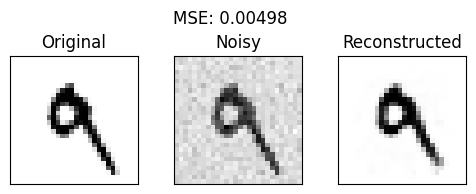

In [241]:
visualize_reconstruction(dae, test_data, test_label, eps=0.1)

## Layer-wise pretraining

In [ ]:
layers = [784, 512, 256, 128]

deep_dae_pre = DenoisingAutoEncoder(layers)

for i in range(len(layers)-1):
  train(deep_dae_pre, 5, i)
  deep_dae_pre.freeze_layers(i)

test(deep_dae_pre)

Encoder to train:
ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
)
Decoder to train:
ModuleList(
  (0): Linear(in_features=512, out_features=784, bias=True)
  (1): Sigmoid()
)



Test loss: 0.005128433462232351: 100%|██████████| 157/157 [00:01<00:00, 81.47it/s]



Epoch 1 train loss: 0.017296700284127265
Epoch 1 test loss: 0.004465063135169304



Test loss: 0.002759188413619995: 100%|██████████| 157/157 [00:01<00:00, 83.64it/s]



Epoch 2 train loss: 0.003909432567528952
Epoch 2 test loss: 0.002495941215871009



Test loss: 0.001731302822008729: 100%|██████████| 157/157 [00:02<00:00, 78.35it/s]



Epoch 3 train loss: 0.002840440507843169
Epoch 3 test loss: 0.0019179373923214568



Test loss: 0.0015929901273921132: 100%|██████████| 157/157 [00:02<00:00, 70.26it/s]



Epoch 4 train loss: 0.002449090113994409
Epoch 4 test loss: 0.0017011590253051584



Test loss: 0.001886631129309535: 100%|██████████| 157/157 [00:02<00:00, 72.92it/s]



Epoch 5 train loss: 0.0022488551401495457
Epoch 5 test loss: 0.001508025887754455

Encoder to train:
ModuleList(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
)
Decoder to train:
ModuleList(
  (0): Linear(in_features=256, out_features=512, bias=True)
  (1): ReLU()
)



Test loss: 0.10940076410770416: 100%|██████████| 157/157 [00:01<00:00, 92.28it/s]



Epoch 1 train loss: 0.25626822373569647
Epoch 1 test loss: 0.12339149363291492



Test loss: 0.11918848752975464: 100%|██████████| 157/157 [00:01<00:00, 90.75it/s] 



Epoch 2 train loss: 0.11258742355429796
Epoch 2 test loss: 0.10387470744028213



Test loss: 0.10193288326263428: 100%|██████████| 157/157 [00:01<00:00, 93.31it/s] 



Epoch 3 train loss: 0.10187518572025715
Epoch 3 test loss: 0.09862983687098618



Test loss: 0.10356327891349792: 100%|██████████| 157/157 [00:01<00:00, 96.72it/s] 



Epoch 4 train loss: 0.0985383378592
Epoch 4 test loss: 0.0964091806939453



Test loss: 0.10409864038228989: 100%|██████████| 157/157 [00:01<00:00, 92.63it/s] 



Epoch 5 train loss: 0.09734491048368818
Epoch 5 test loss: 0.0963693021019553

Encoder to train:
ModuleList(
  (0): Linear(in_features=256, out_features=128, bias=True)
  (1): ReLU()
)
Decoder to train:
ModuleList(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
)



Test loss: 0.6833202838897705: 100%|██████████| 157/157 [00:01<00:00, 97.86it/s] 



Epoch 1 train loss: 0.9643388593883149
Epoch 1 test loss: 0.6703473451031241



Test loss: 0.5643795728683472: 100%|██████████| 157/157 [00:01<00:00, 92.33it/s] 



Epoch 2 train loss: 0.5856136668846805
Epoch 2 test loss: 0.5600735934296991



Test loss: 0.4923284947872162: 100%|██████████| 157/157 [00:01<00:00, 102.71it/s]



Epoch 3 train loss: 0.5454527922212951
Epoch 3 test loss: 0.5468105804768337



Test loss: 0.6143147945404053: 100%|██████████| 157/157 [00:01<00:00, 90.26it/s] 



Epoch 4 train loss: 0.5387269553027427
Epoch 4 test loss: 0.5448623366036992



Test loss: 0.5045849084854126: 100%|██████████| 157/157 [00:01<00:00, 101.53it/s]



Epoch 5 train loss: 0.5365216470222229
Epoch 5 test loss: 0.5422432153088272

Test loss: 0.01932766554865298



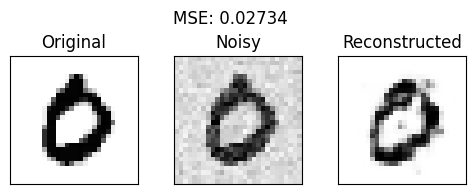

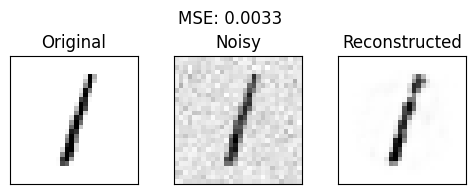

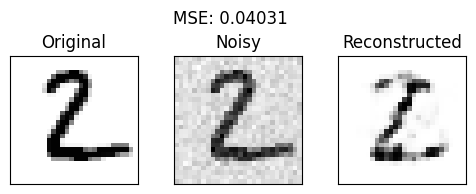

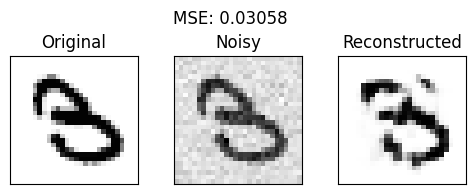

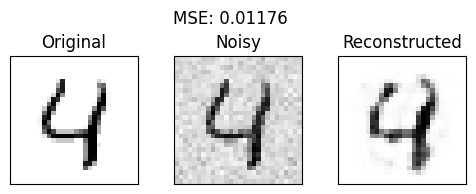

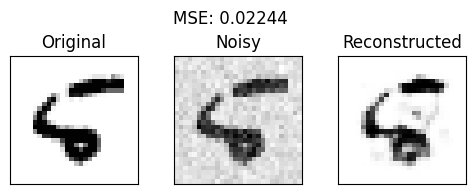

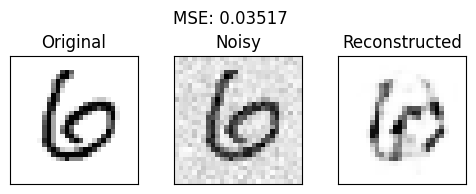

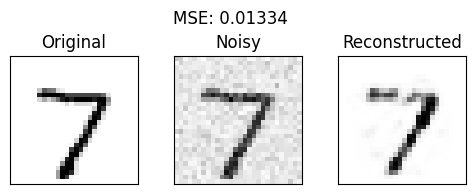

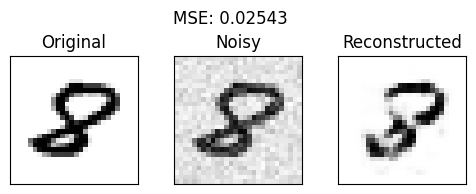

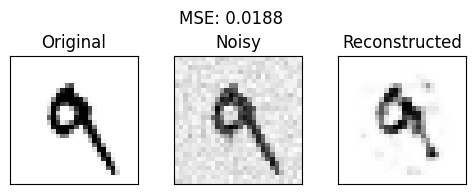

In [242]:
visualize_reconstruction(deep_dae_pre, test_data, test_label, eps=0.1)

## Fine-tuning the pre-trained model



Test loss: 0.005807016044855118: 100%|██████████| 157/157 [00:02<00:00, 73.93it/s]



Epoch 1 train loss: 0.007508786713907014
Epoch 1 test loss: 0.004923266355707577



Test loss: 0.003532105591148138: 100%|██████████| 157/157 [00:02<00:00, 64.05it/s]



Epoch 2 train loss: 0.005495258661082336
Epoch 2 test loss: 0.004407152462347298



Test loss: 0.003851039567962289: 100%|██████████| 157/157 [00:02<00:00, 61.50it/s]



Epoch 3 train loss: 0.00520914657287665
Epoch 3 test loss: 0.004244280099619631



Test loss: 0.004116584546864033: 100%|██████████| 157/157 [00:02<00:00, 72.32it/s]



Epoch 4 train loss: 0.005004816430944529
Epoch 4 test loss: 0.004243628025517627



Test loss: 0.003916154615581036: 100%|██████████| 157/157 [00:02<00:00, 65.14it/s]



Epoch 5 train loss: 0.0048690263101501445
Epoch 5 test loss: 0.004098907635090457



Test loss: 0.004732430446892977: 100%|██████████| 157/157 [00:02<00:00, 72.82it/s]



Epoch 6 train loss: 0.004657138792325312
Epoch 6 test loss: 0.004165683496316337



Test loss: 0.00377831282094121: 100%|██████████| 157/157 [00:03<00:00, 52.16it/s]



Epoch 7 train loss: 0.004552586727948395
Epoch 7 test loss: 0.0038964749020257384



Test loss: 0.0037099523469805717: 100%|██████████| 157/157 [00:02<00:00, 71.76it/s]



Epoch 8 train loss: 0.004427584407201756
Epoch 8 test loss: 0.0037559311759842048



Test loss: 0.0030069826170802116: 100%|██████████| 157/157 [00:02<00:00, 59.42it/s]



Epoch 9 train loss: 0.00433781231988841
Epoch 9 test loss: 0.0035559133964644116



Test loss: 0.0032436789479106665: 100%|██████████| 157/157 [00:02<00:00, 70.11it/s]



Epoch 10 train loss: 0.00424358669493689
Epoch 10 test loss: 0.003587910201056463



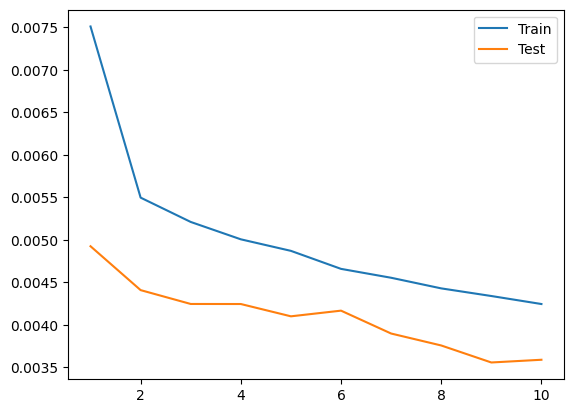

Test loss: 0.0035896896826589754



In [216]:
deep_dae_tuned = copy.deepcopy(deep_dae_pre)
deep_dae_tuned.unfreeze_parameters()
train_losses, test_losses = train(deep_dae_tuned, 10)
plot_learning_curves(train_losses, test_losses)
test(deep_dae_tuned)

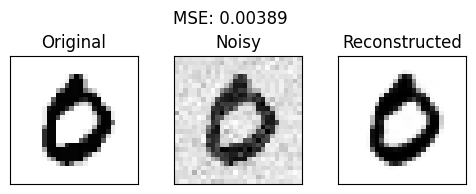

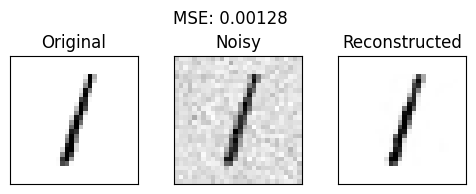

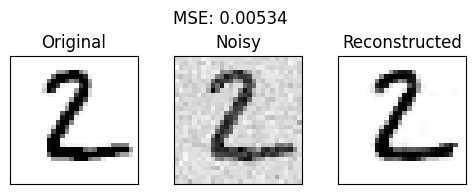

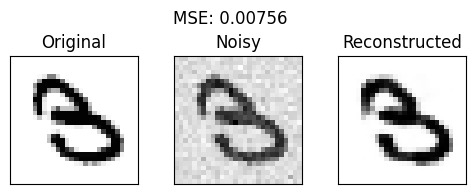

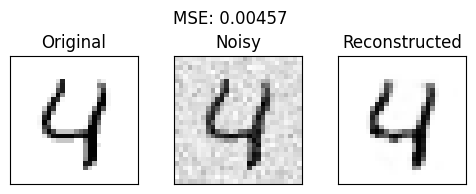

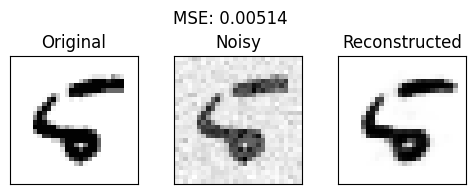

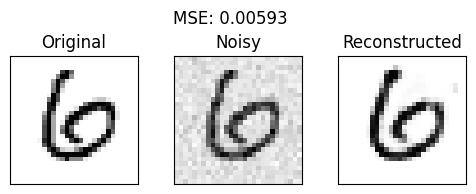

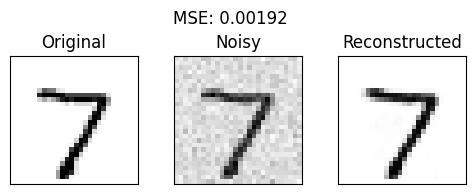

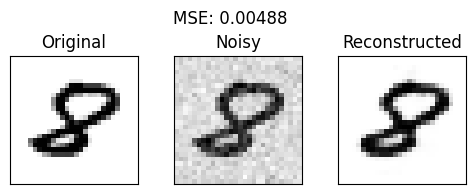

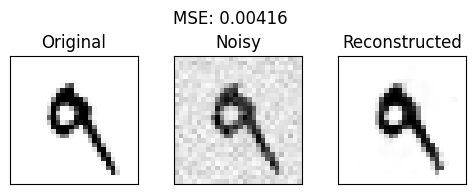

In [243]:
visualize_reconstruction(deep_dae_tuned, test_data, test_label, eps=0.1)

## Direct training with no layer-wise pretraining

Test loss: 0.015320288948714733: 100%|██████████| 157/157 [00:02<00:00, 58.43it/s]



Epoch 1 train loss: 0.03663805079088409
Epoch 1 test loss: 0.019703290057457558



Test loss: 0.012189623899757862: 100%|██████████| 157/157 [00:02<00:00, 68.59it/s]



Epoch 2 train loss: 0.017106988631101498
Epoch 2 test loss: 0.01355194714466098



Test loss: 0.010839340277016163: 100%|██████████| 157/157 [00:02<00:00, 76.82it/s]



Epoch 3 train loss: 0.012737296093731865
Epoch 3 test loss: 0.010654789051574886



Test loss: 0.009280424565076828: 100%|██████████| 157/157 [00:02<00:00, 75.85it/s]



Epoch 4 train loss: 0.010634234423306323
Epoch 4 test loss: 0.00928246753681807



Test loss: 0.0077388836070895195: 100%|██████████| 157/157 [00:03<00:00, 41.41it/s]



Epoch 5 train loss: 0.0095006750905509
Epoch 5 test loss: 0.008500666310120919



Test loss: 0.006761940196156502: 100%|██████████| 157/157 [00:02<00:00, 70.34it/s]



Epoch 6 train loss: 0.00868926833925852
Epoch 6 test loss: 0.008019548354397533



Test loss: 0.004976780153810978: 100%|██████████| 157/157 [00:02<00:00, 73.30it/s]



Epoch 7 train loss: 0.008047402209377906
Epoch 7 test loss: 0.007133679737331001



Test loss: 0.006563142873346806: 100%|██████████| 157/157 [00:02<00:00, 75.49it/s]



Epoch 8 train loss: 0.007639552691955365
Epoch 8 test loss: 0.006979941405284747



Test loss: 0.007743183057755232: 100%|██████████| 157/157 [00:02<00:00, 73.94it/s]



Epoch 9 train loss: 0.007281827908664593
Epoch 9 test loss: 0.006718376099731132



Test loss: 0.0063054743222892284: 100%|██████████| 157/157 [00:02<00:00, 71.91it/s]



Epoch 10 train loss: 0.006986523060493473
Epoch 10 test loss: 0.006526996111675243



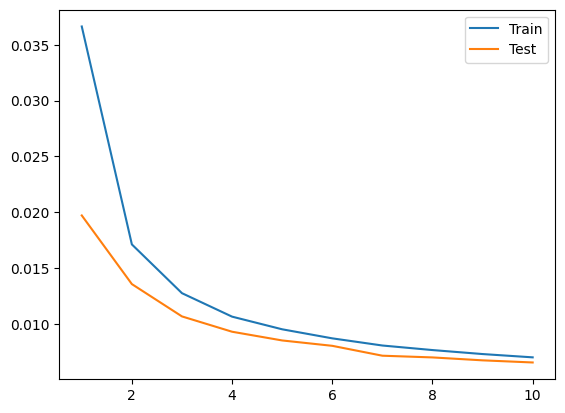

Test loss: 0.006530960223928189



In [183]:
deep_dae = DenoisingAutoEncoder([784, 512, 256, 128])
train_losses, test_losses = train(deep_dae, 10)
plot_learning_curves(train_losses, test_losses)
test(deep_dae)

## Interpolation

### Interpolation between images of the same class

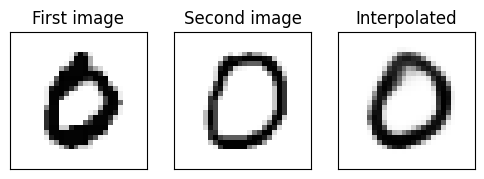

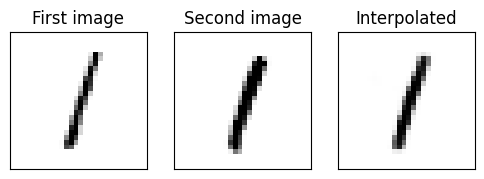

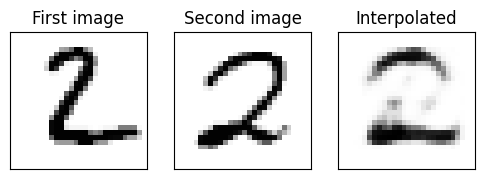

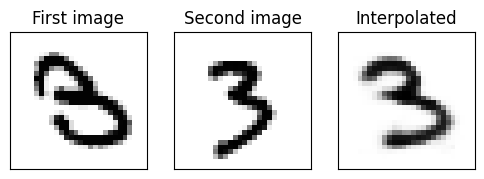

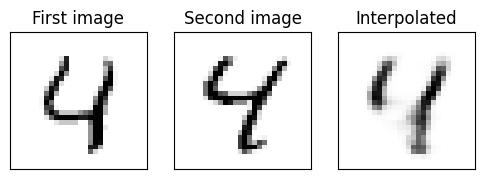

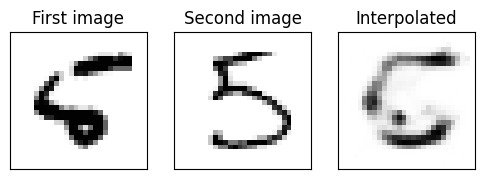

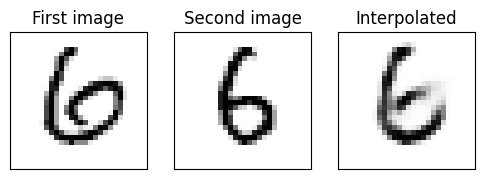

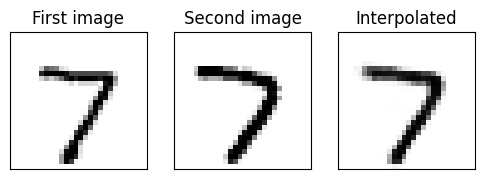

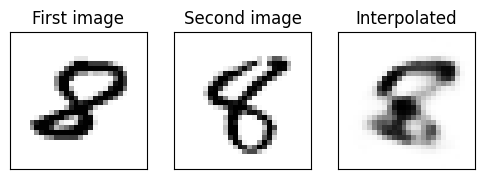

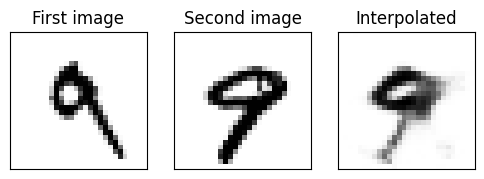

In [225]:
test_interpolation_same_class(deep_dae, test_data, test_label, alpha=0.5)

### Interpolation between images of different classes

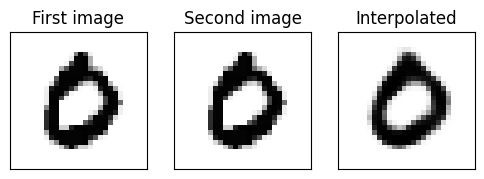

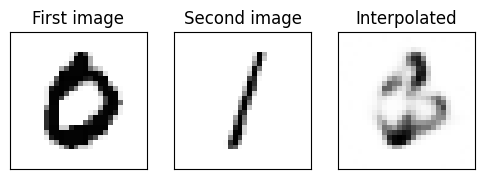

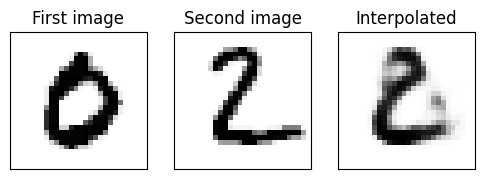

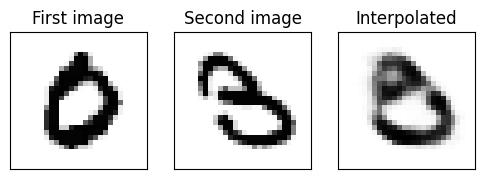

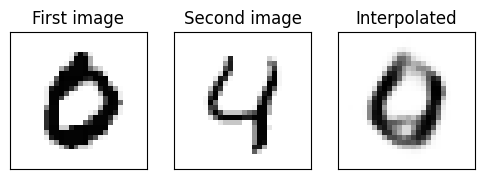

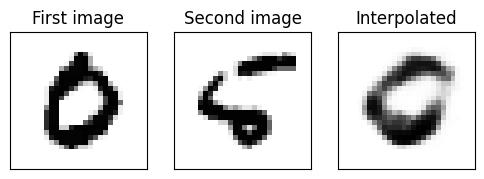

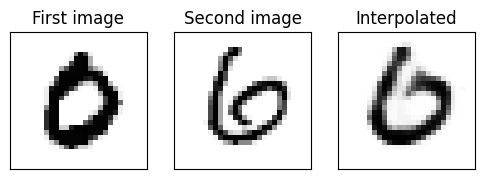

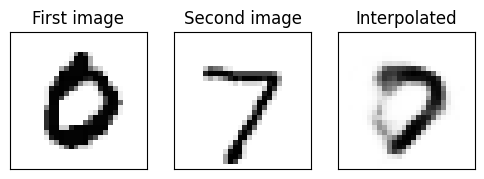

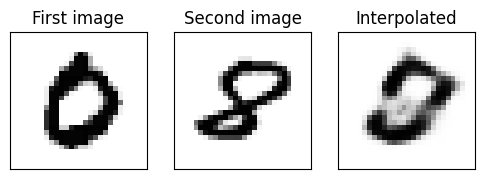

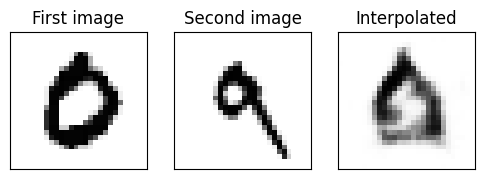

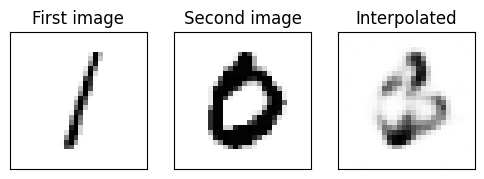

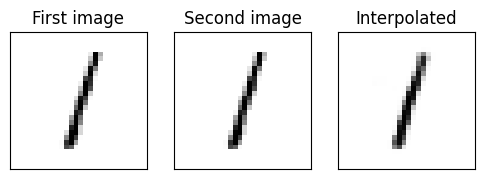

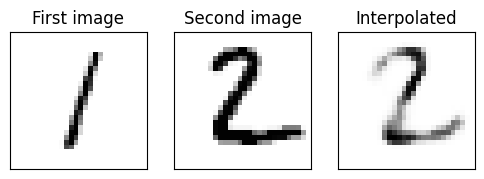

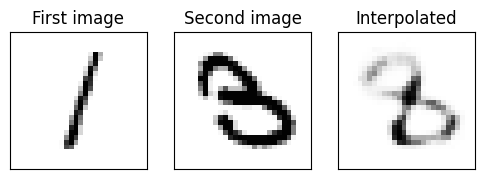

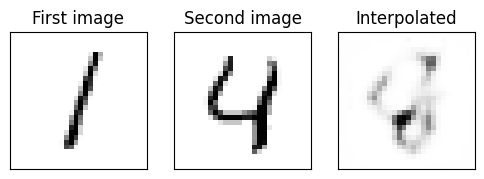

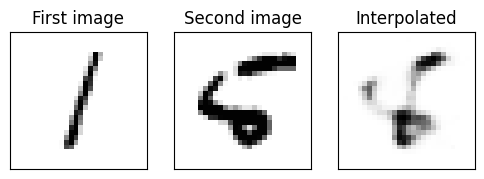

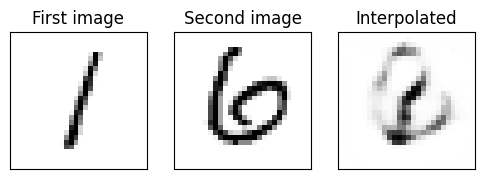

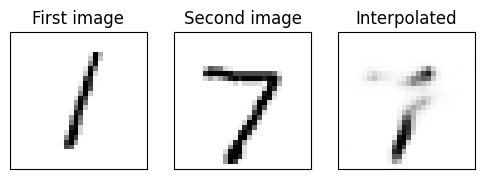

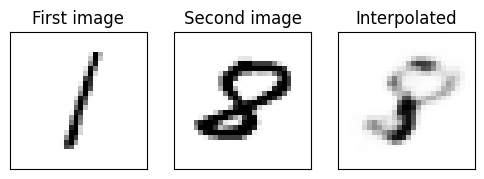

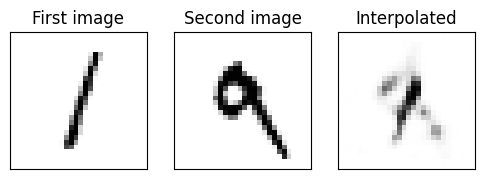

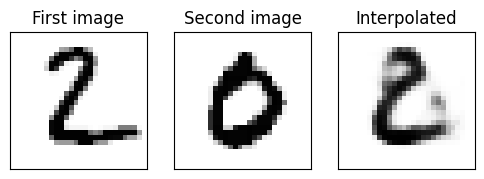

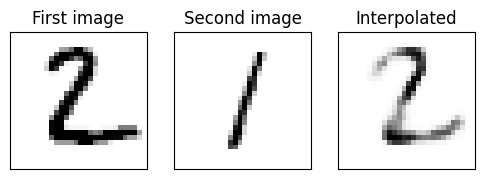

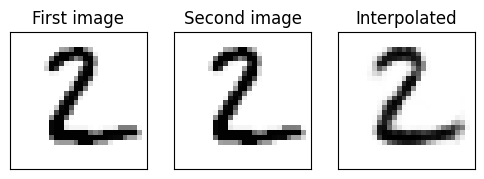

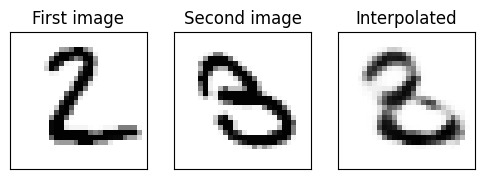

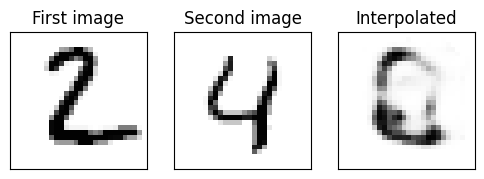

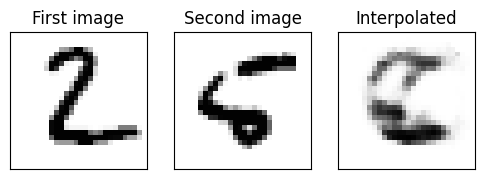

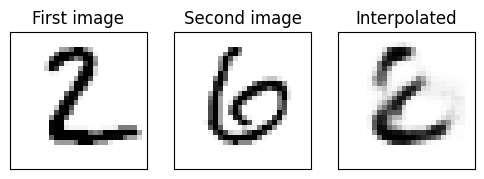

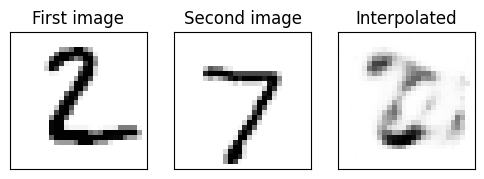

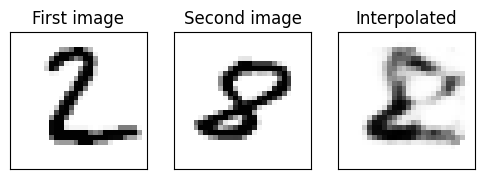

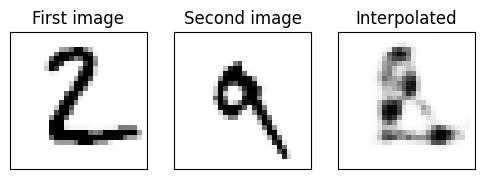

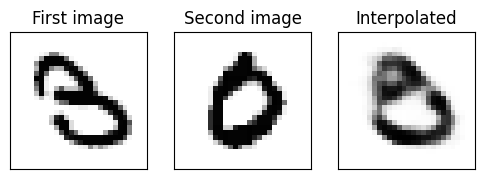

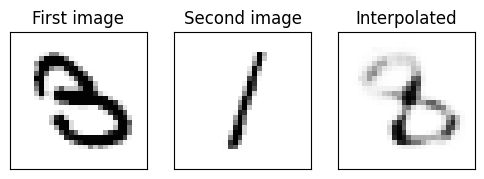

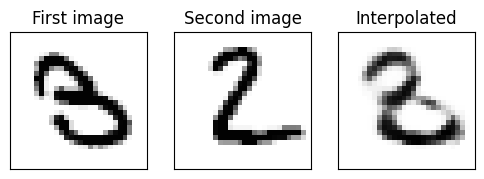

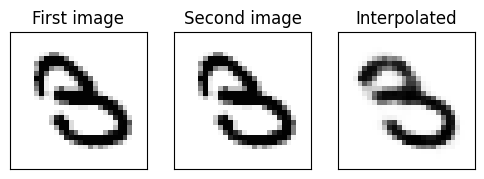

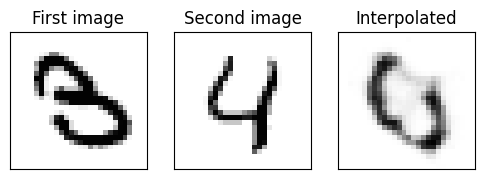

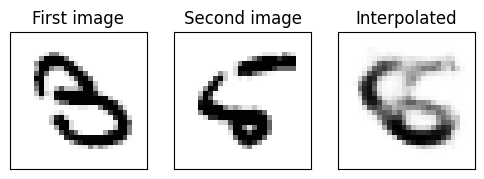

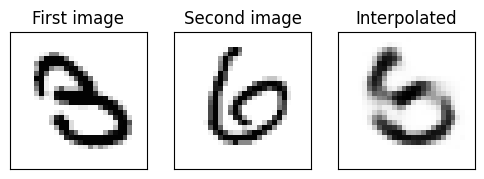

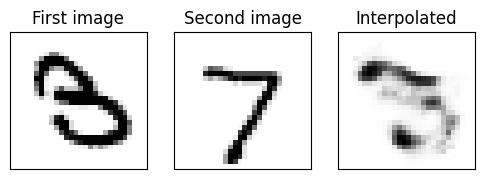

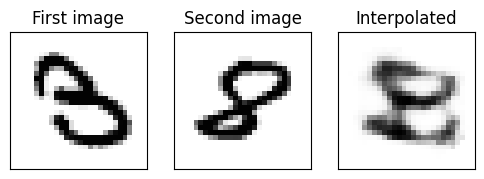

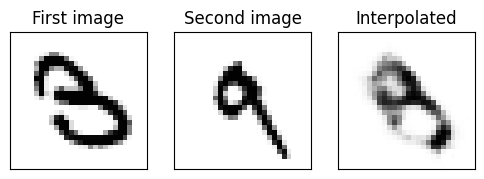

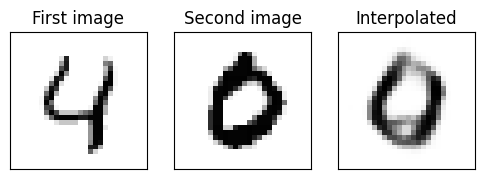

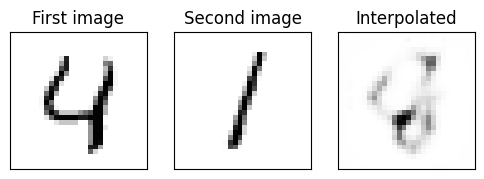

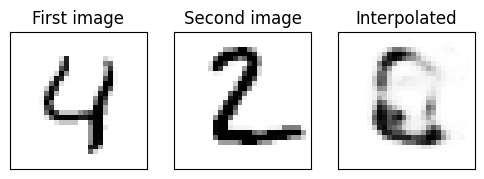

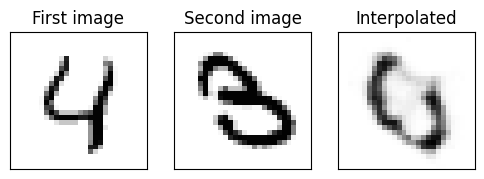

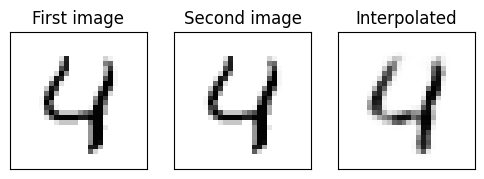

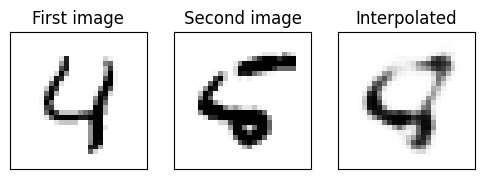

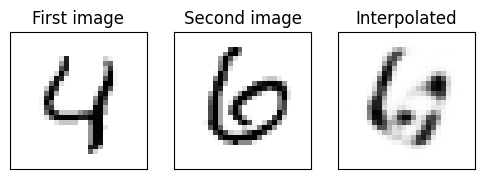

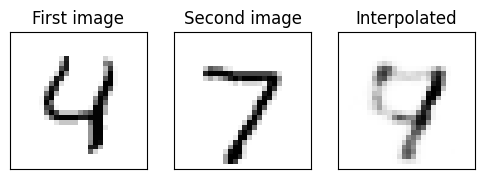

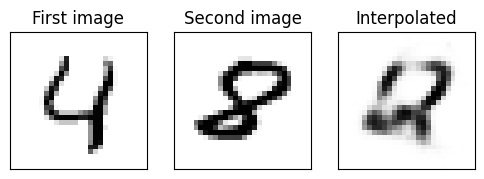

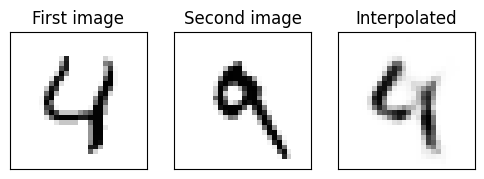

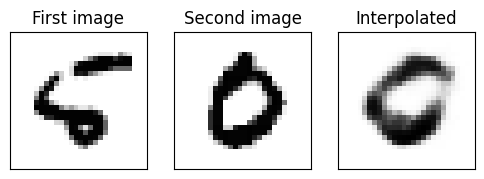

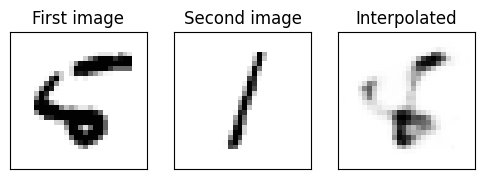

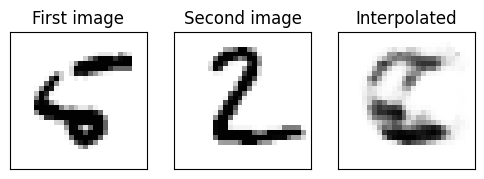

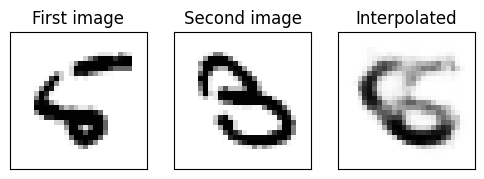

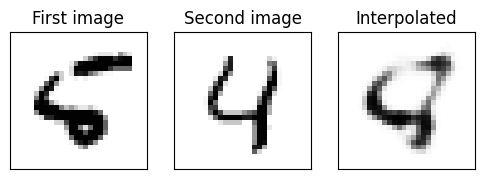

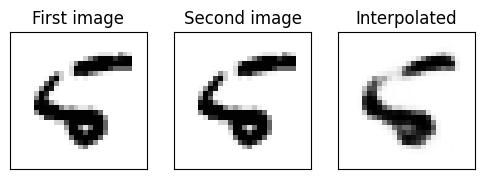

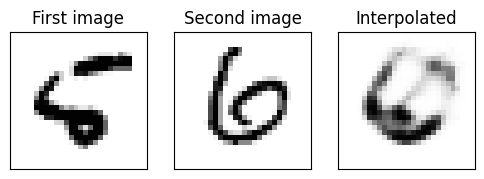

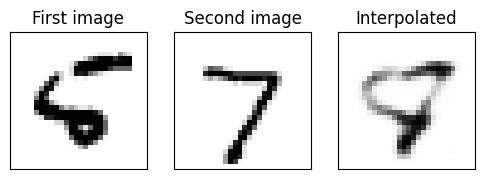

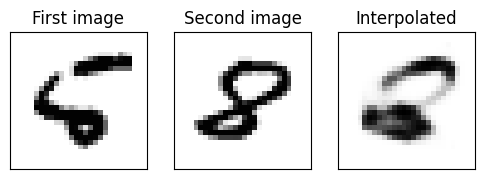

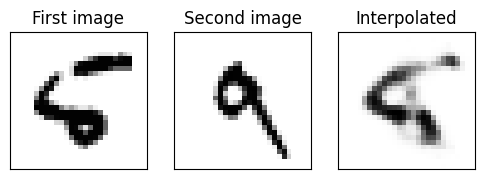

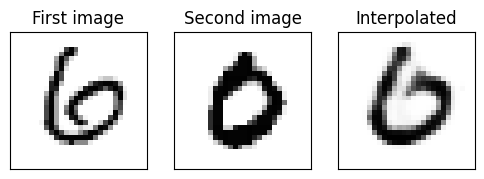

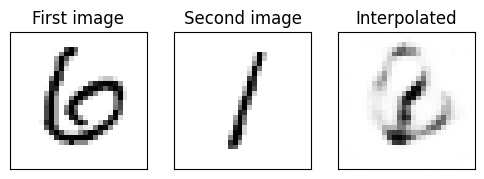

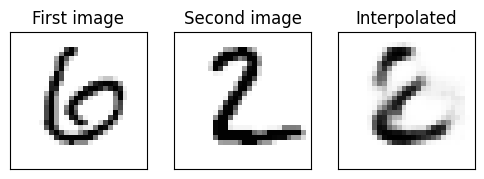

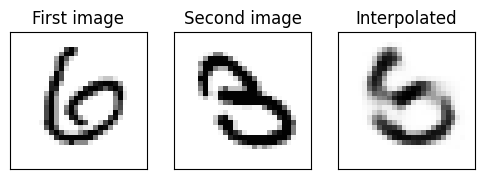

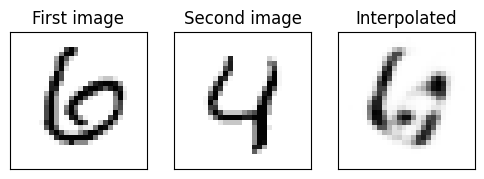

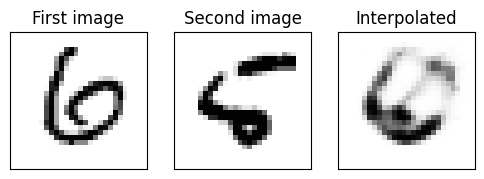

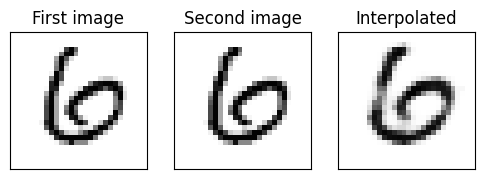

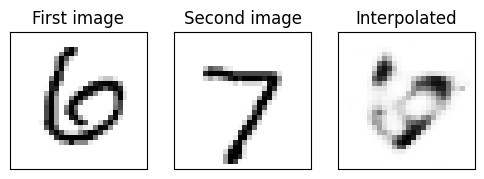

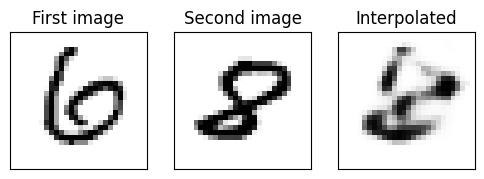

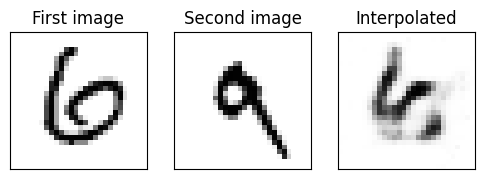

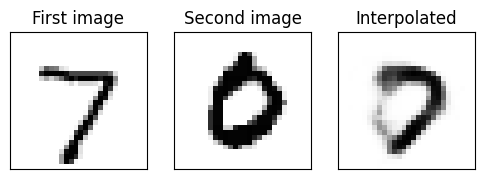

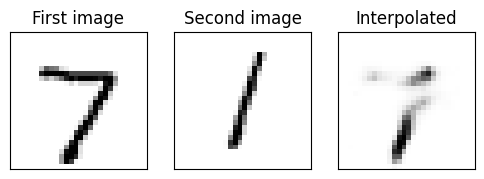

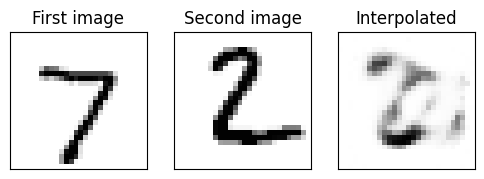

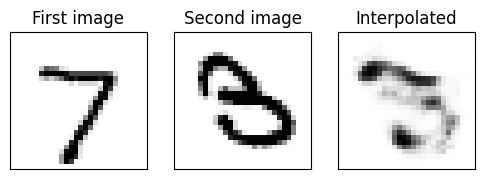

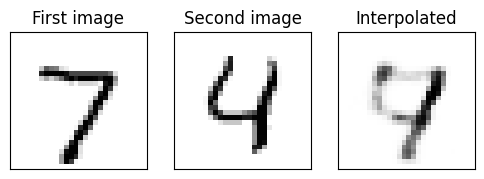

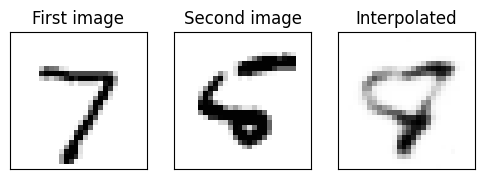

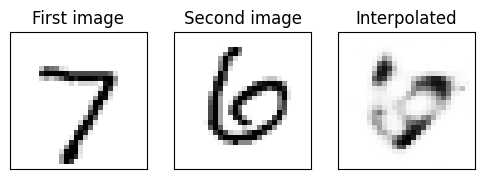

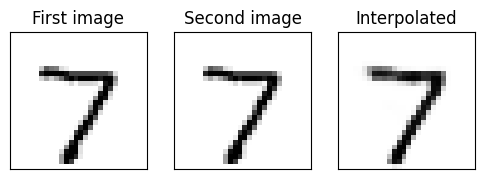

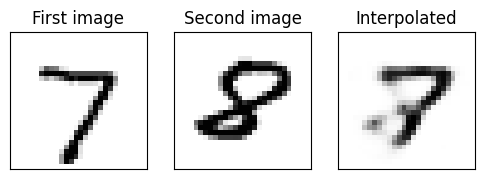

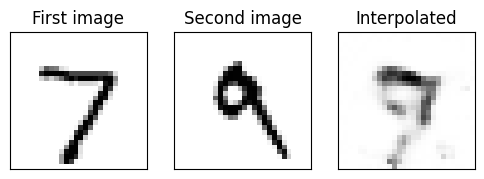

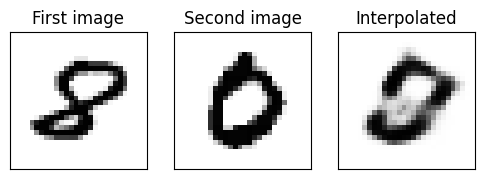

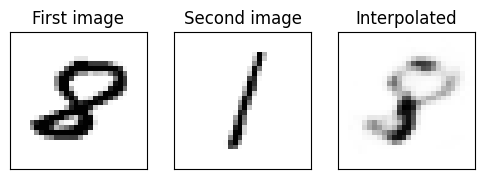

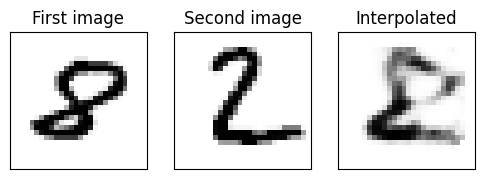

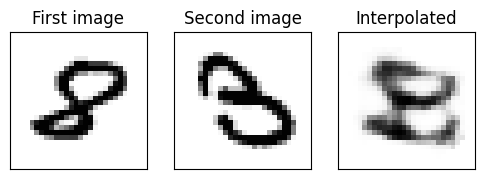

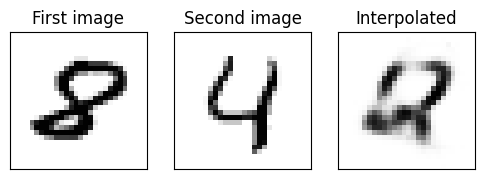

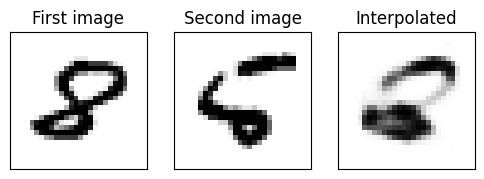

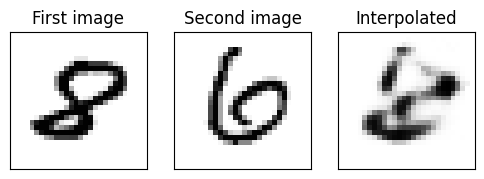

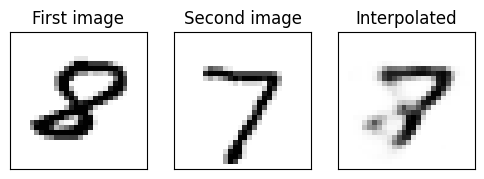

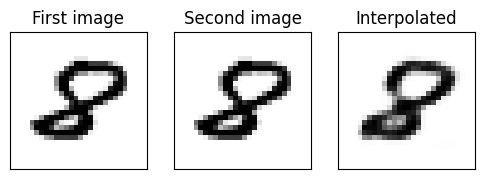

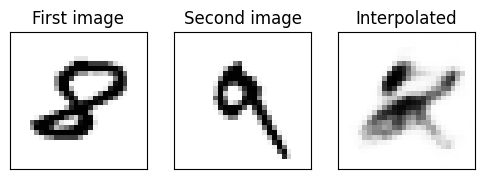

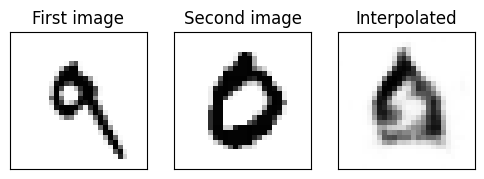

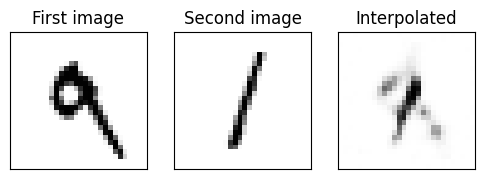

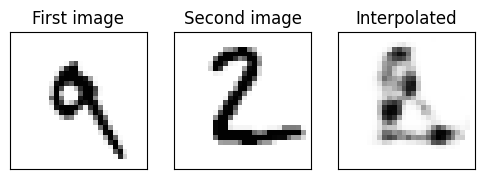

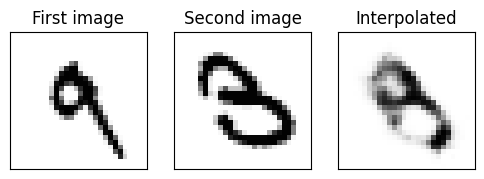

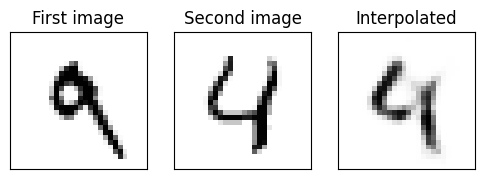

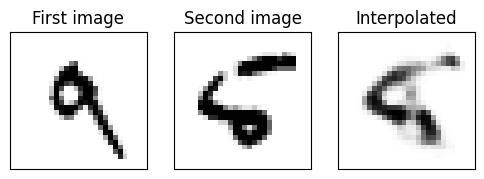

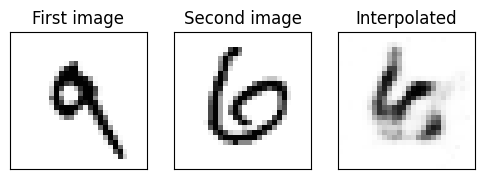

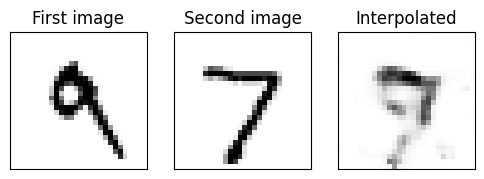

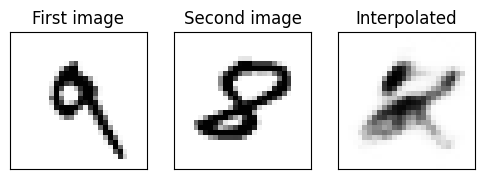

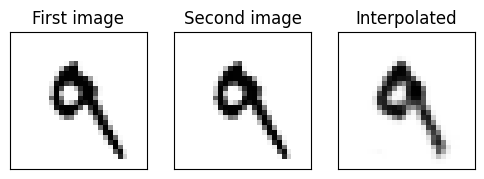

In [213]:
test_interpolation_different_classes(deep_dae, test_data, test_label, alpha=0.5)

### Interpolation with different $\alpha$ values

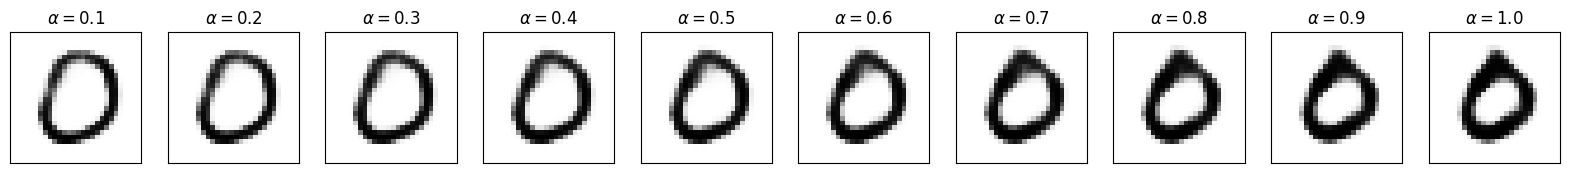

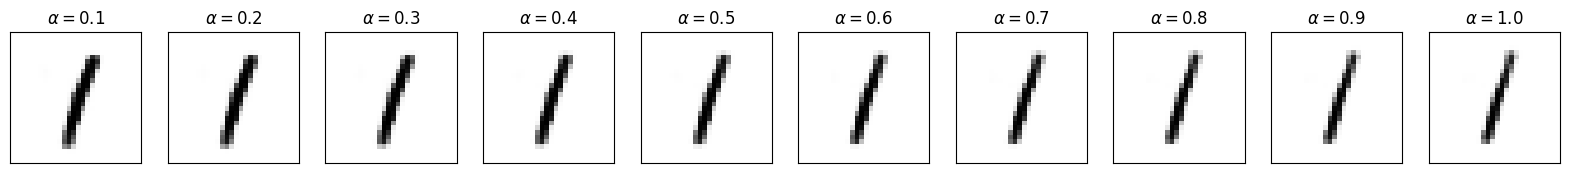

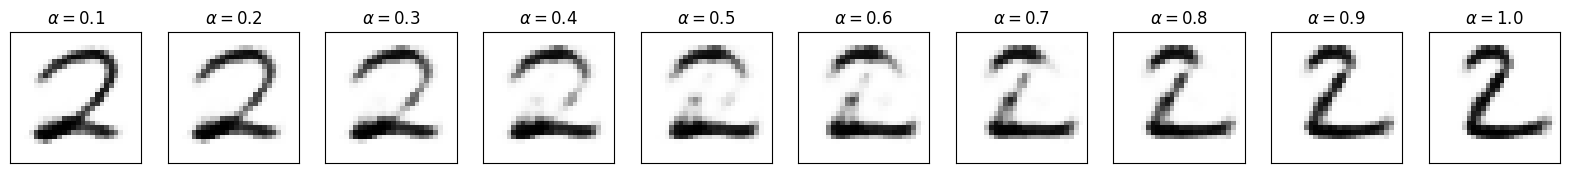

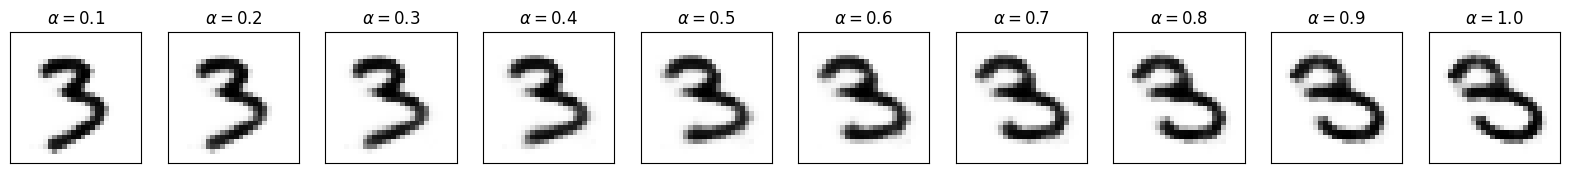

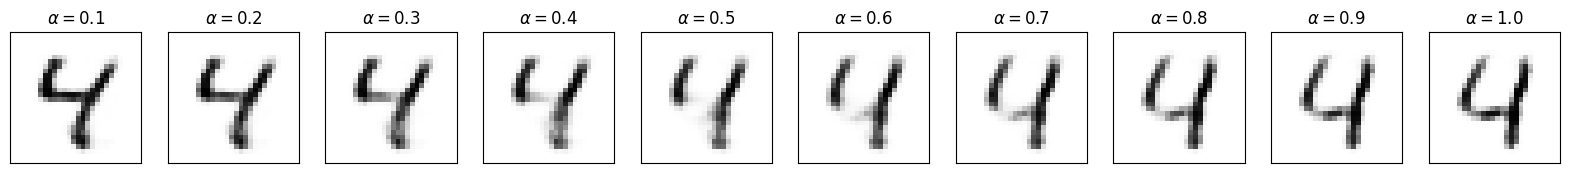

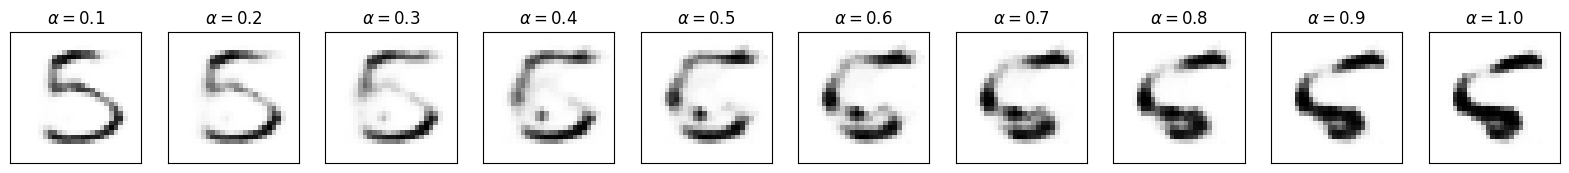

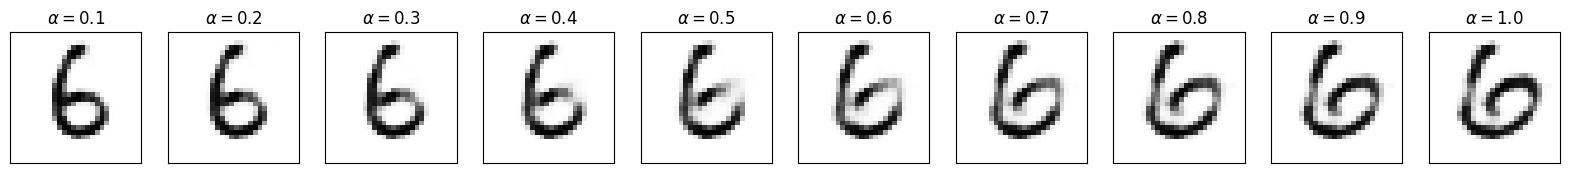

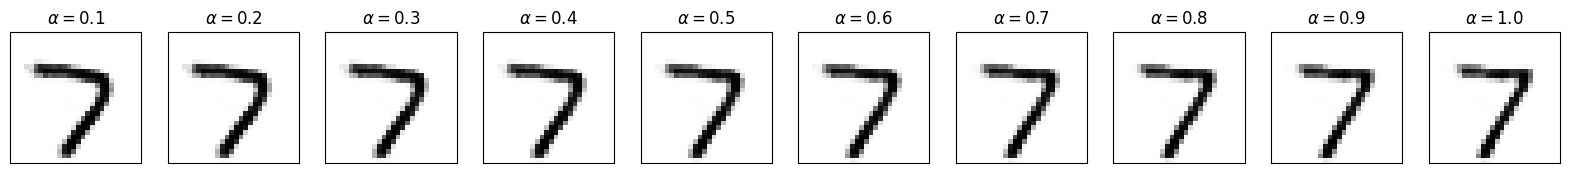

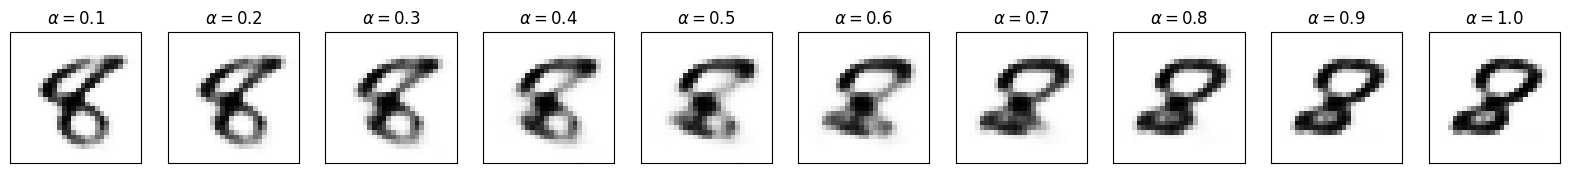

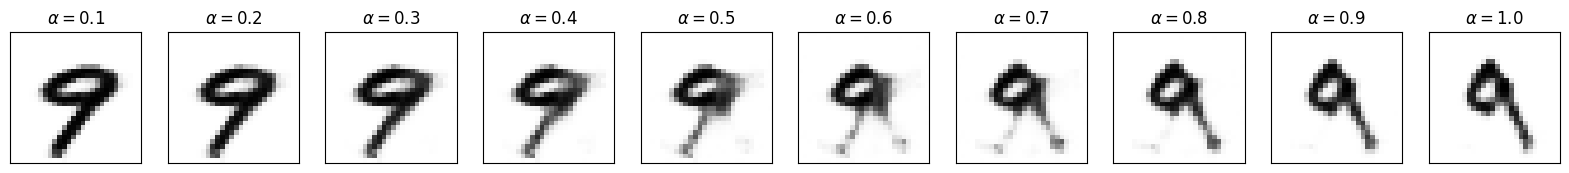

In [205]:
test_interpolation_multiple_alpha_same_class(deep_dae, test_data, test_label)

<ipython-input-207-9cf6a669bb62>:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 10, figsize=(20, 5))


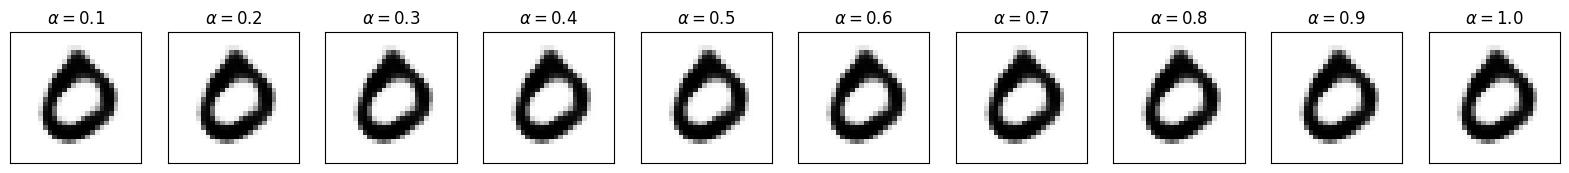

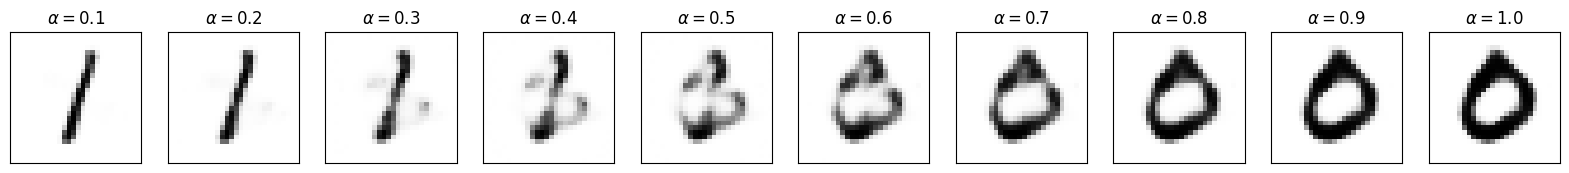

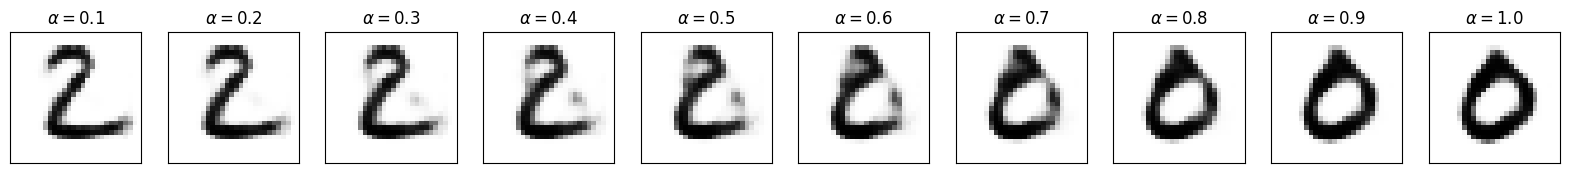

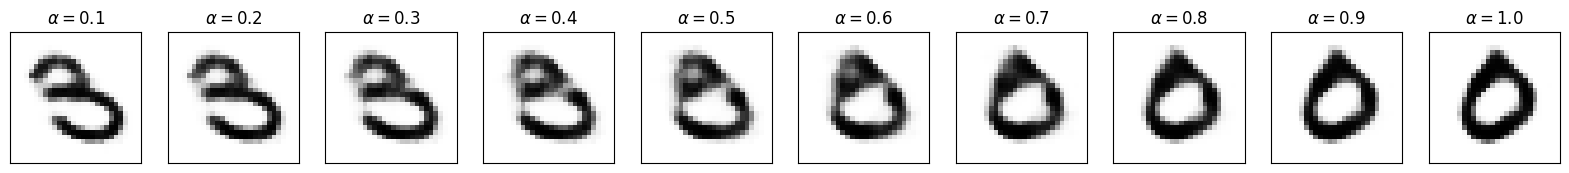

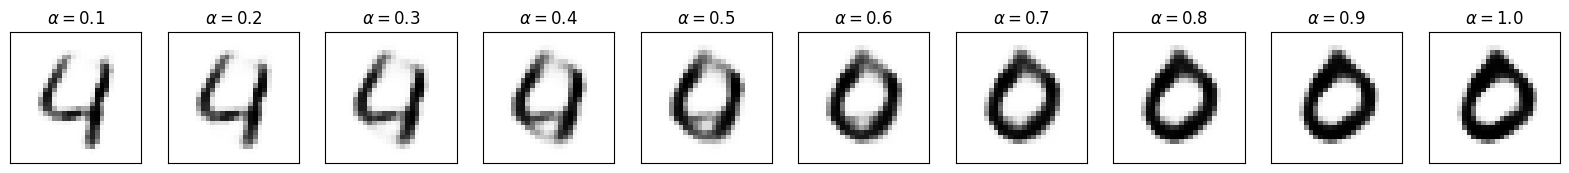

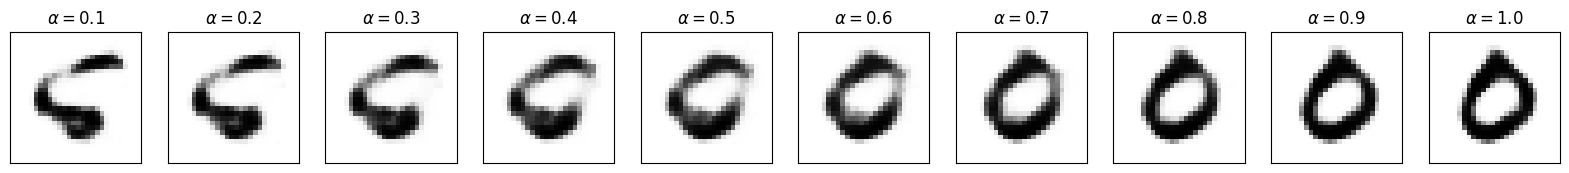

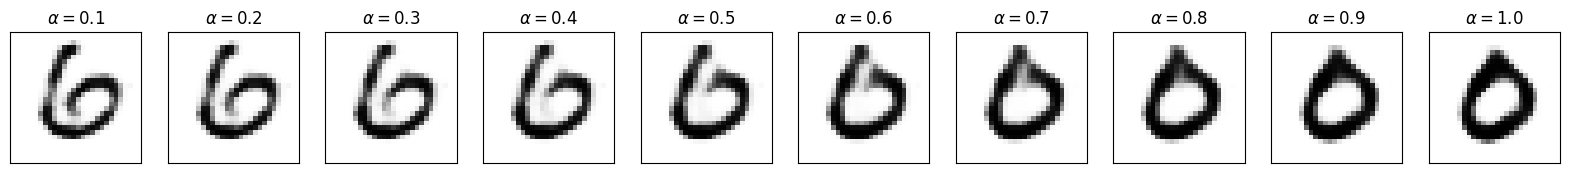

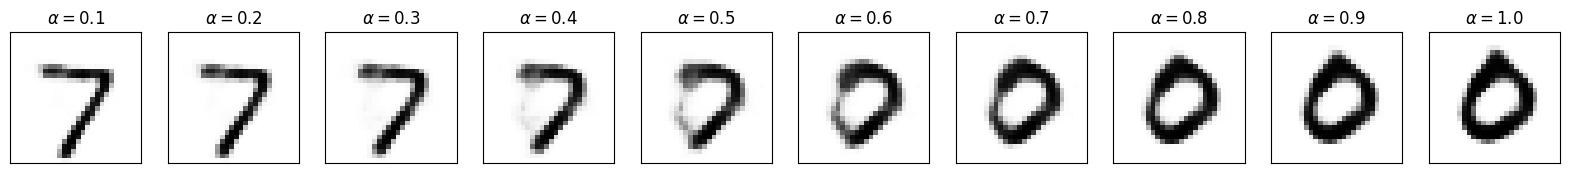

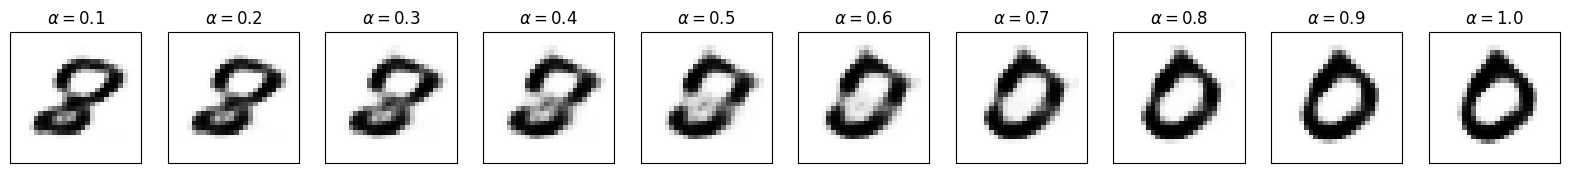

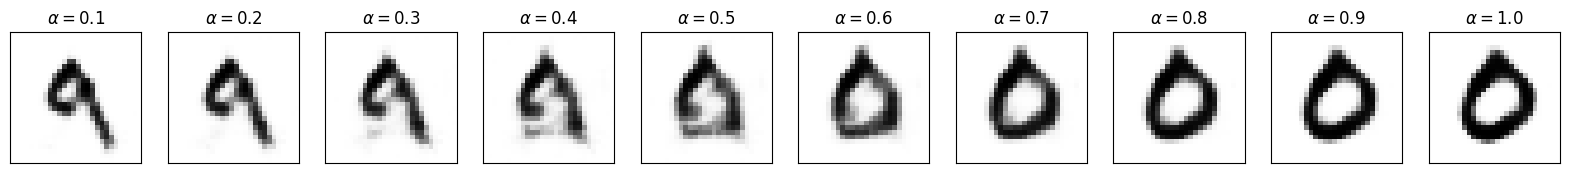

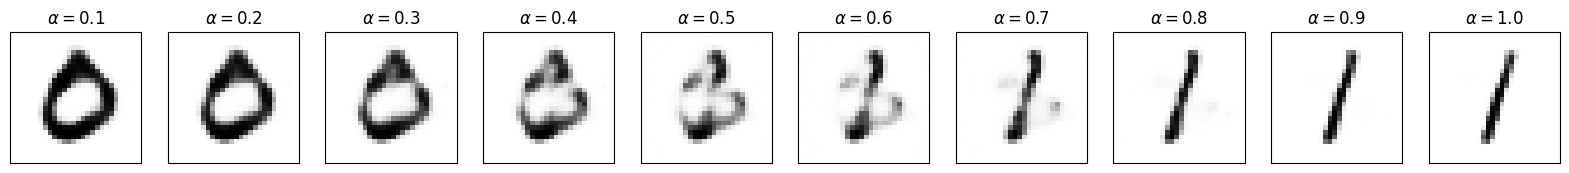

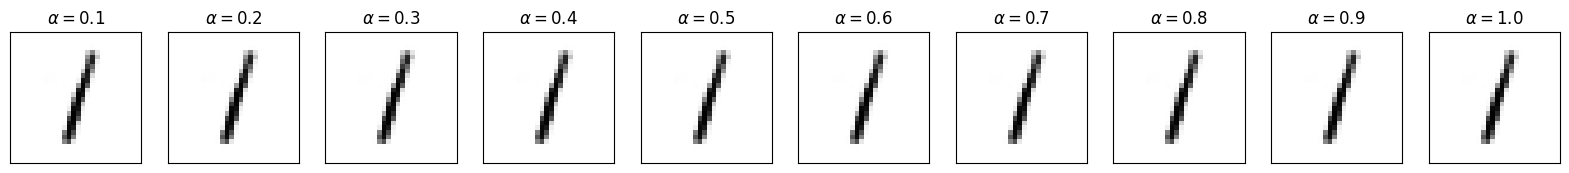

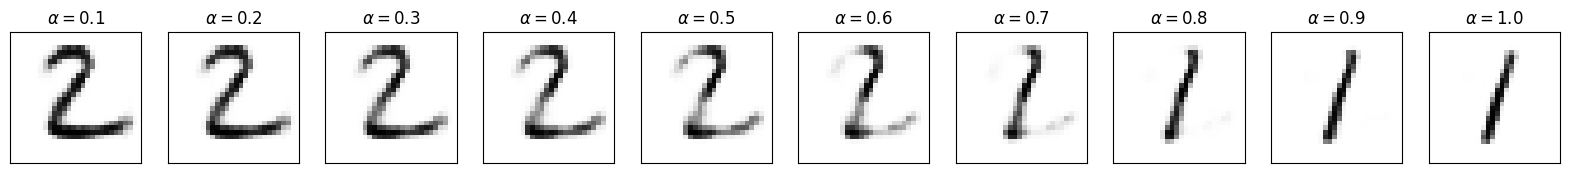

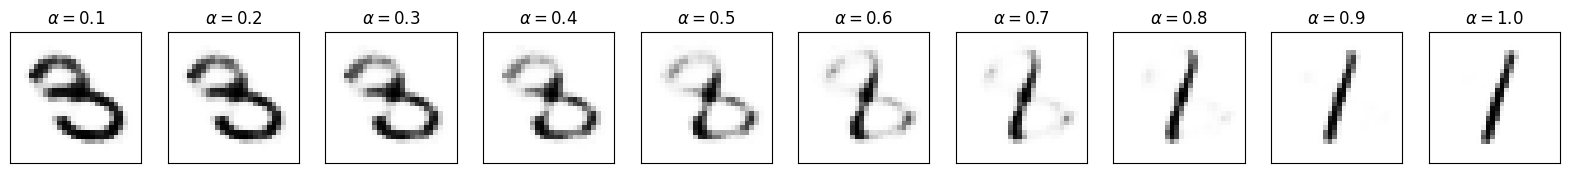

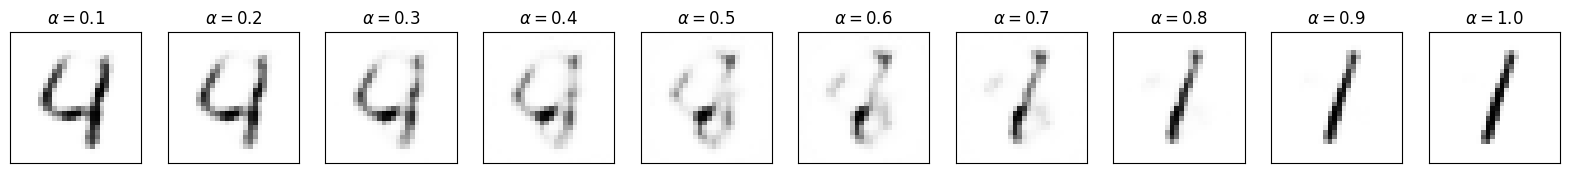

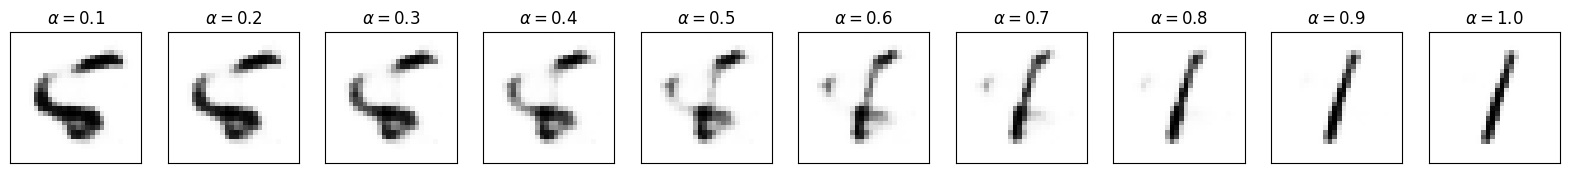

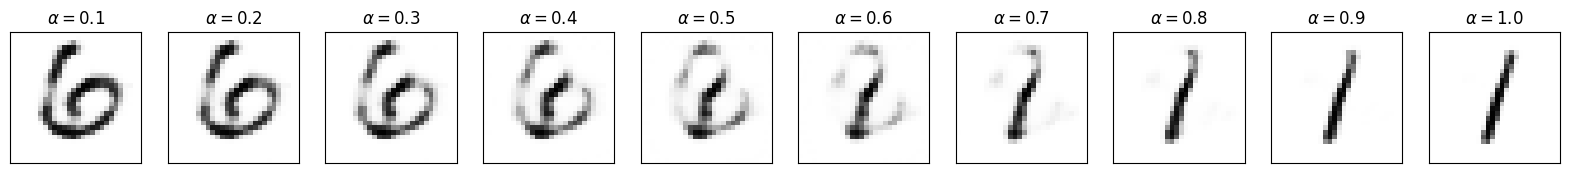

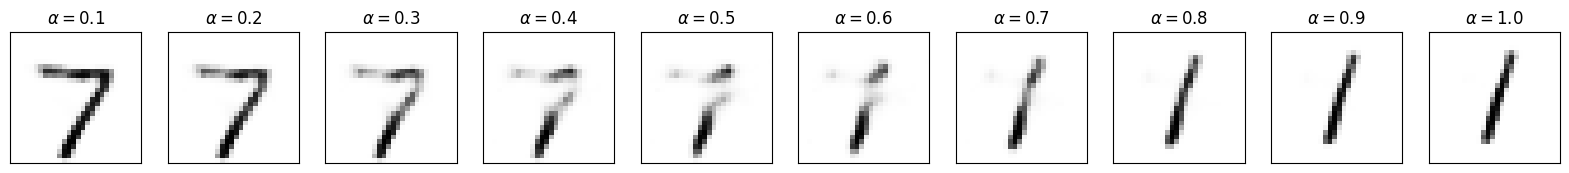

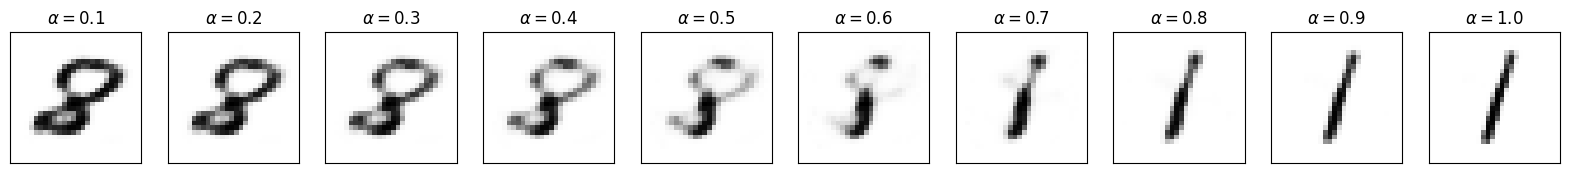

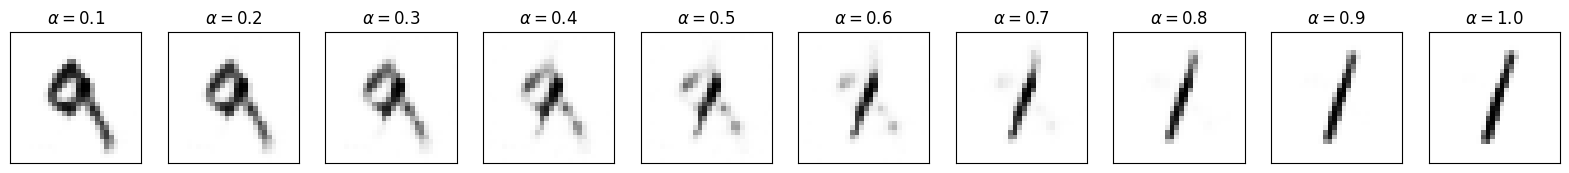

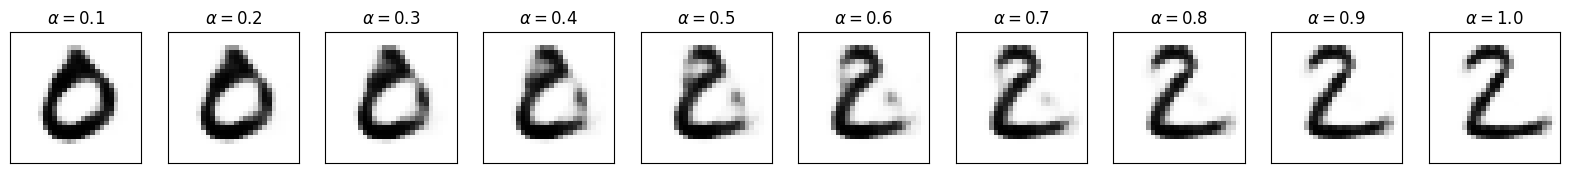

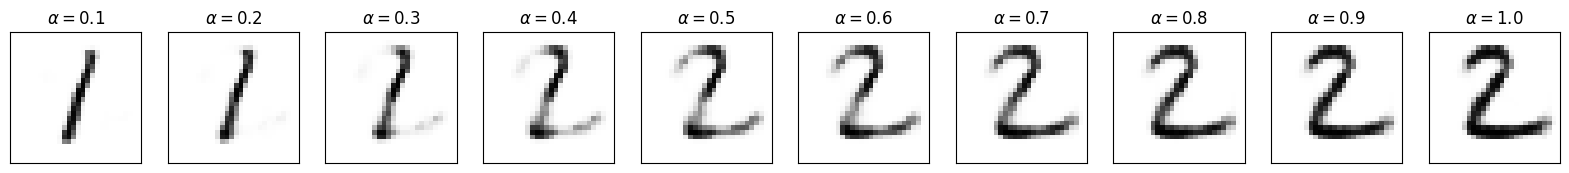

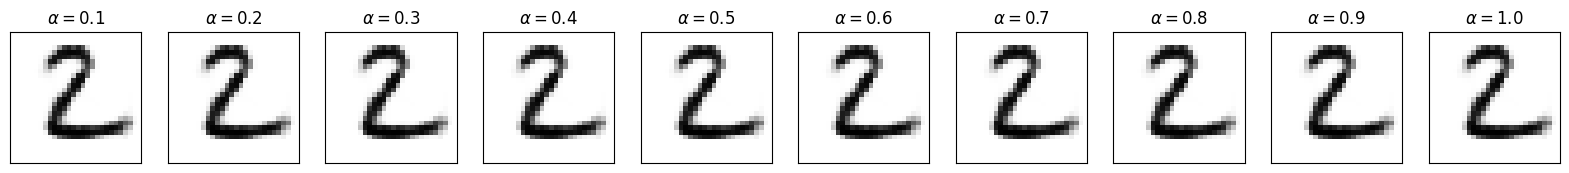

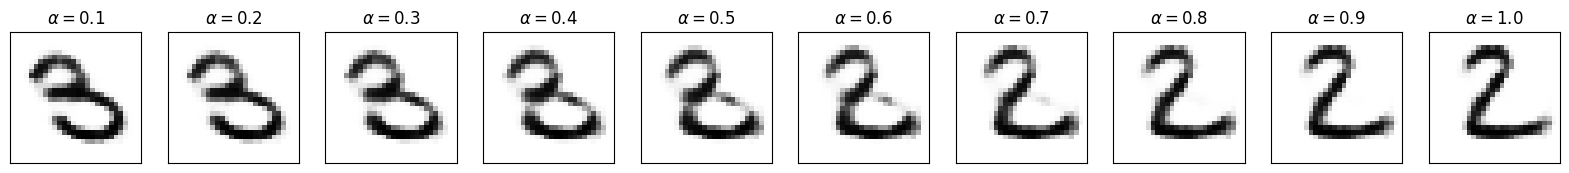

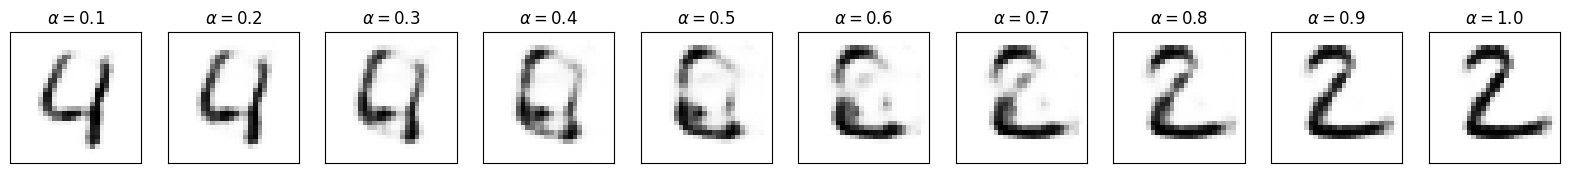

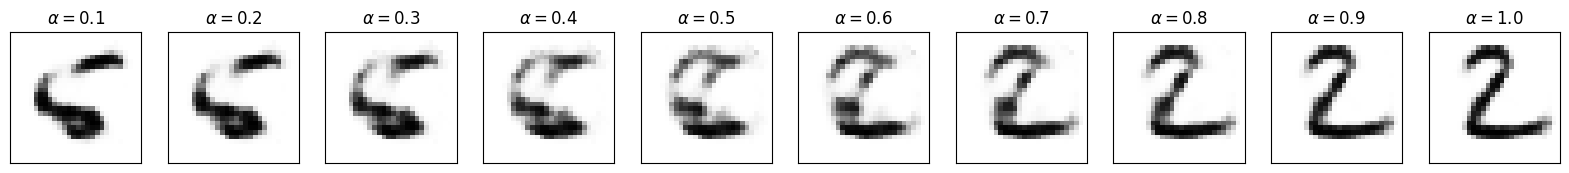

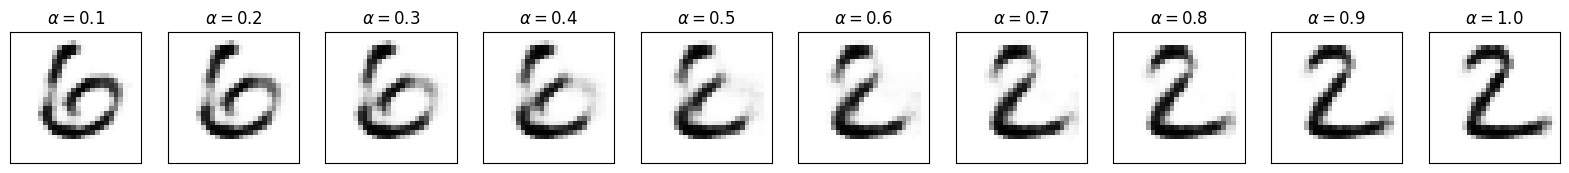

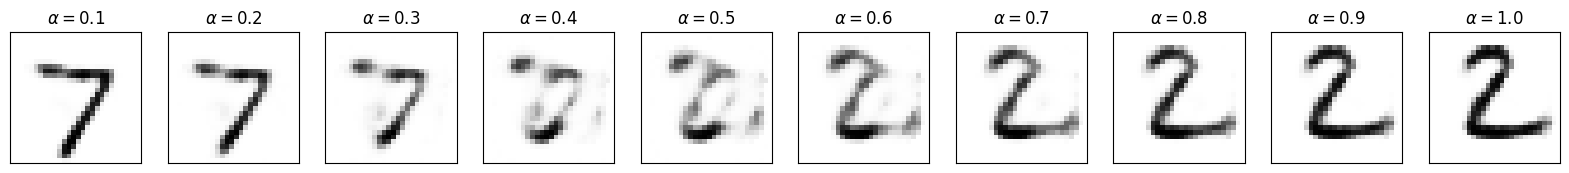

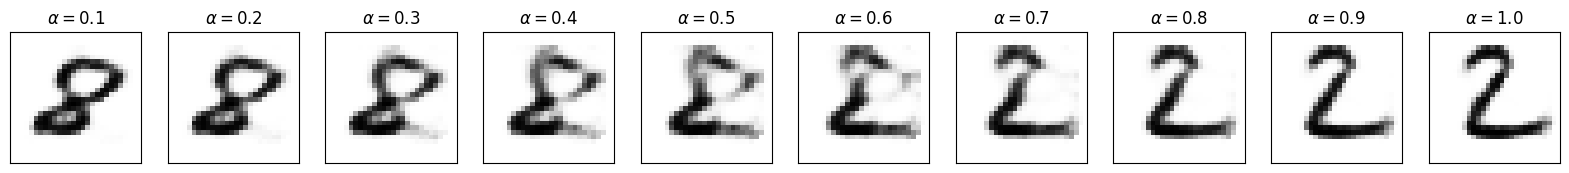

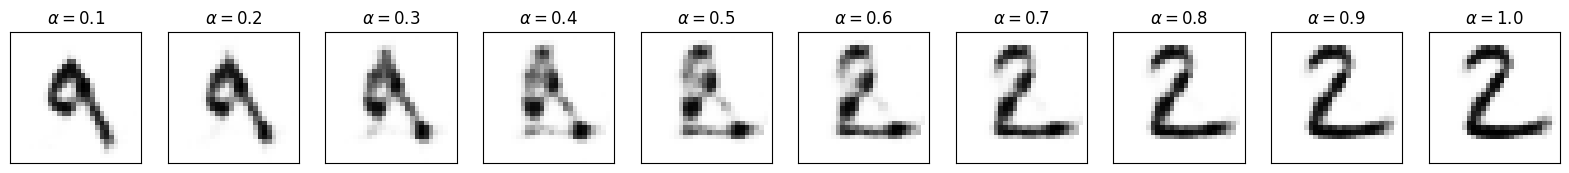

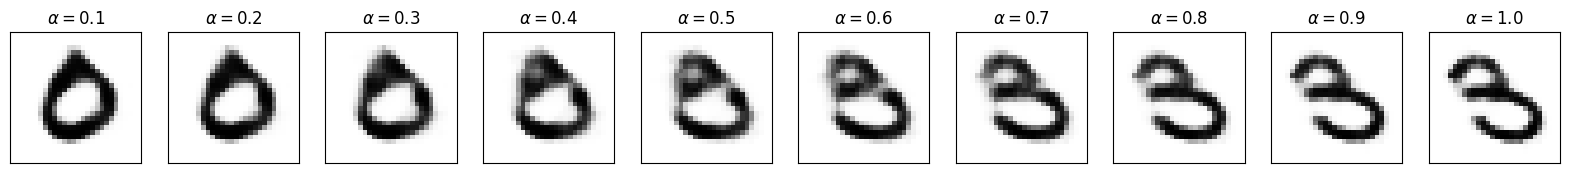

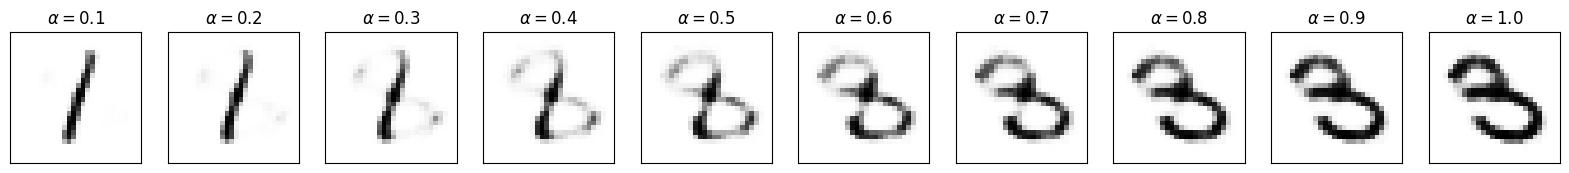

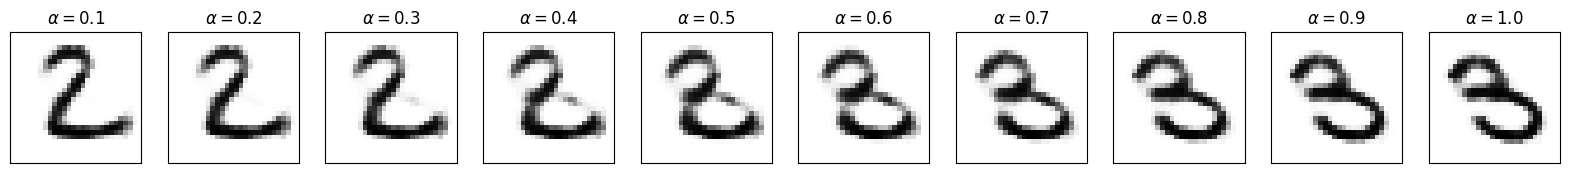

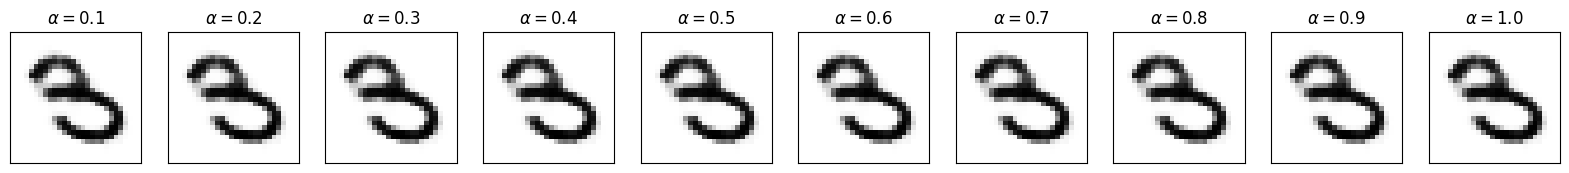

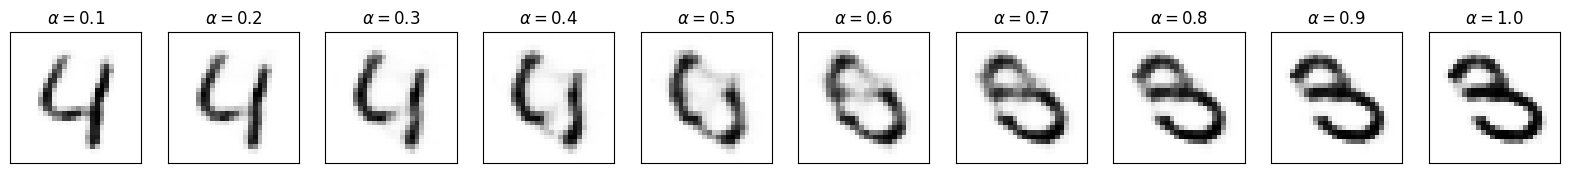

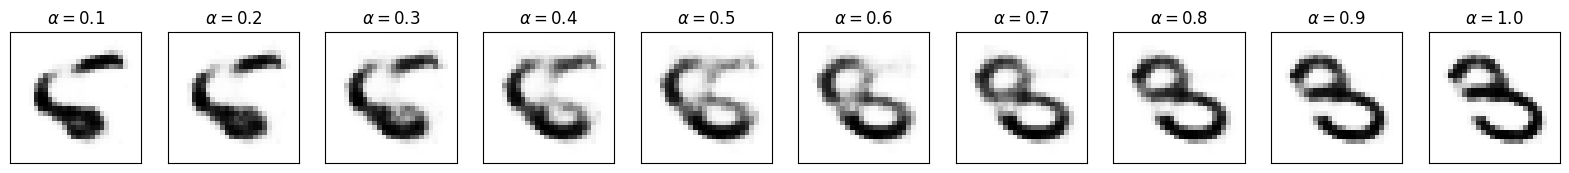

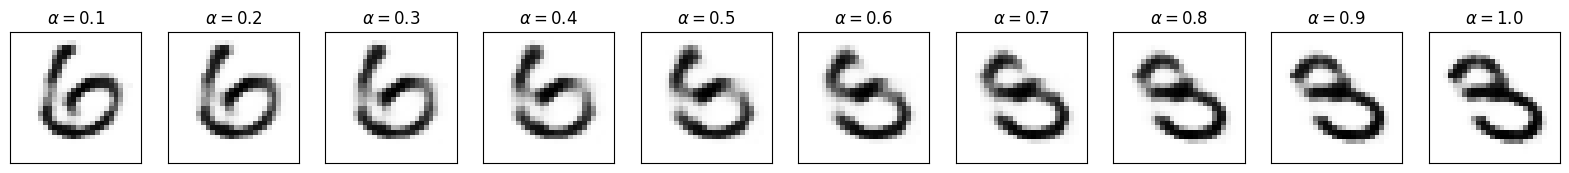

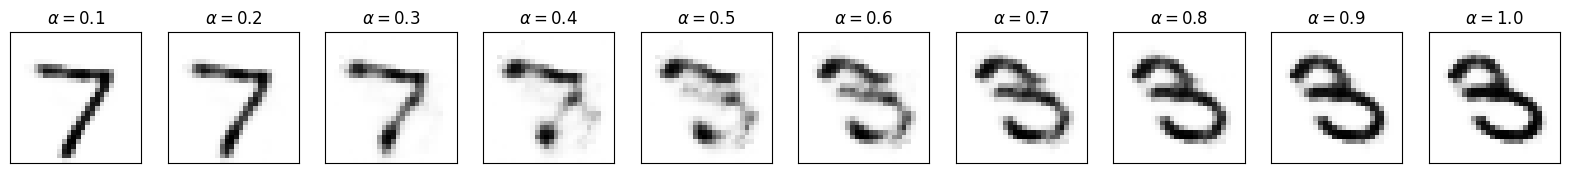

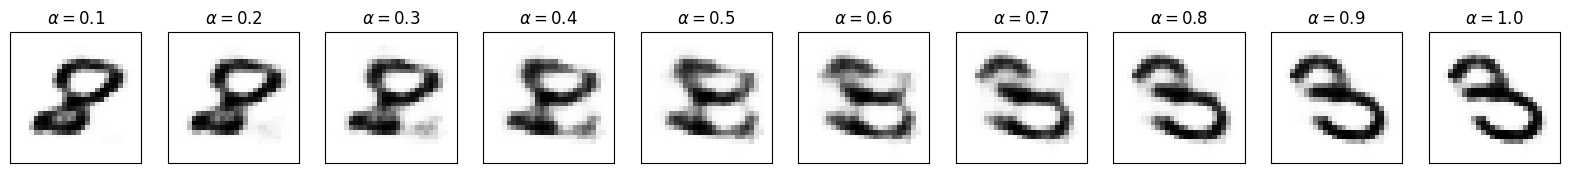

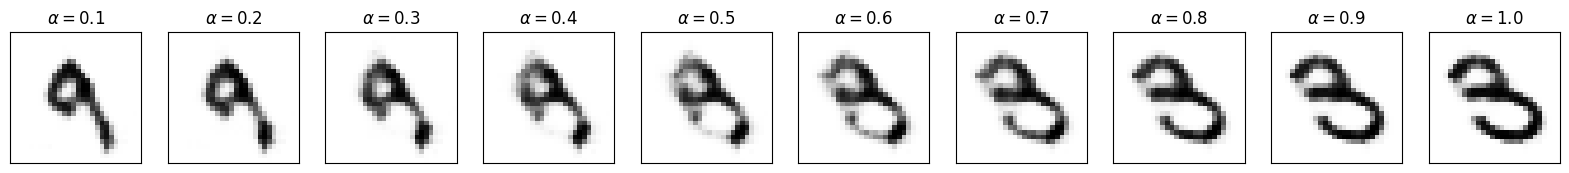

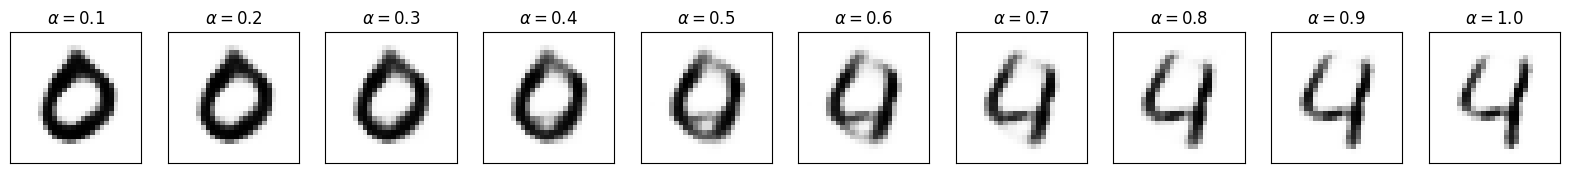

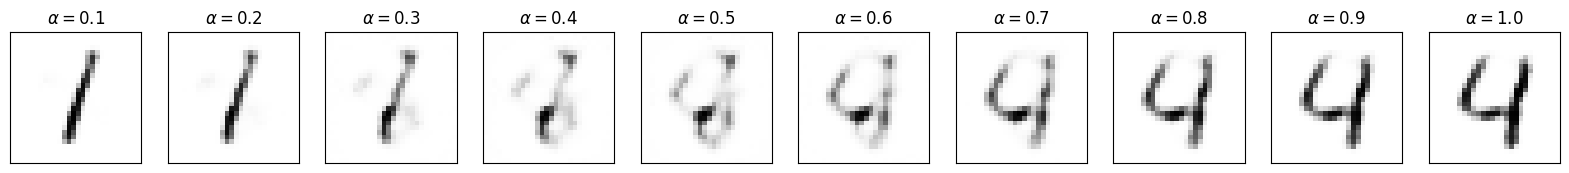

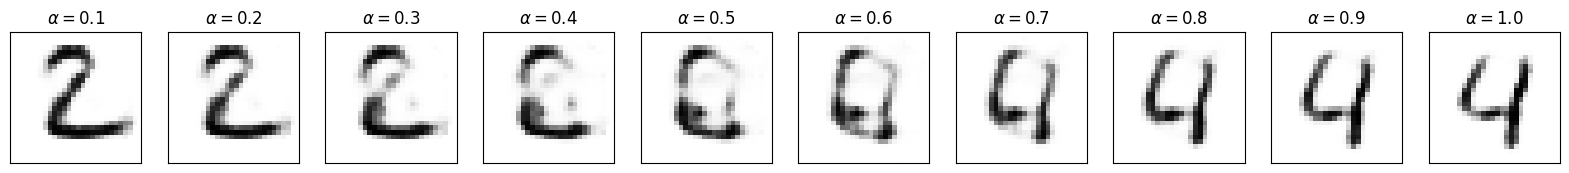

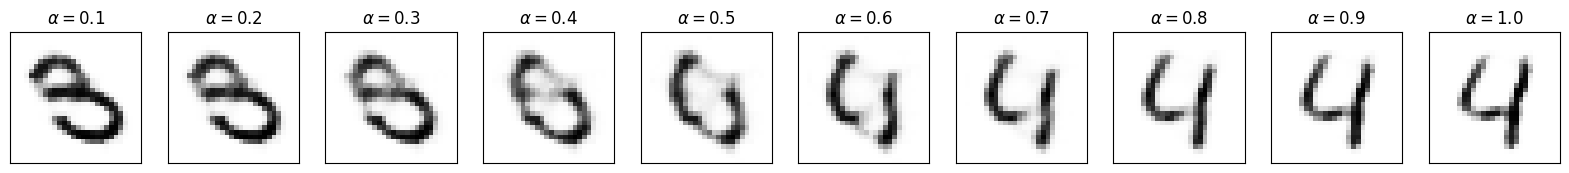

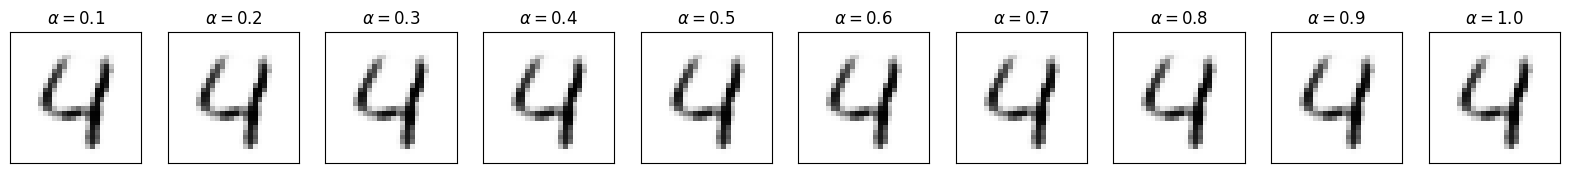

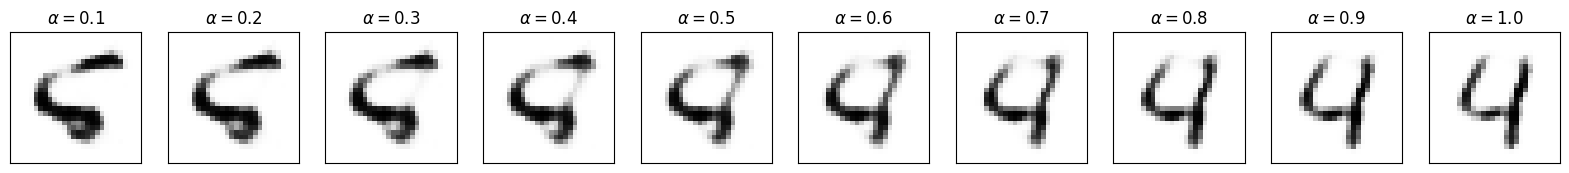

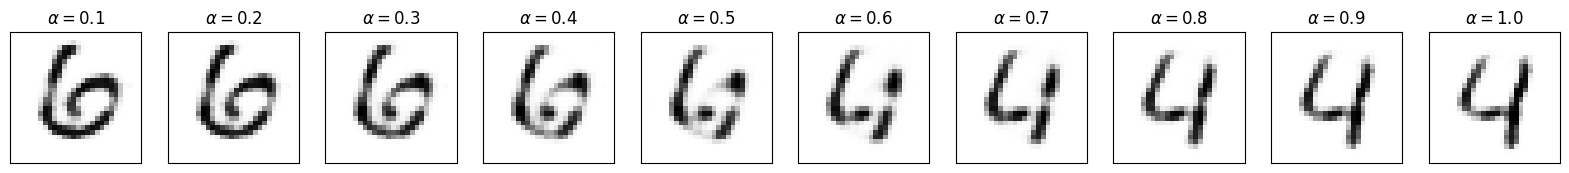

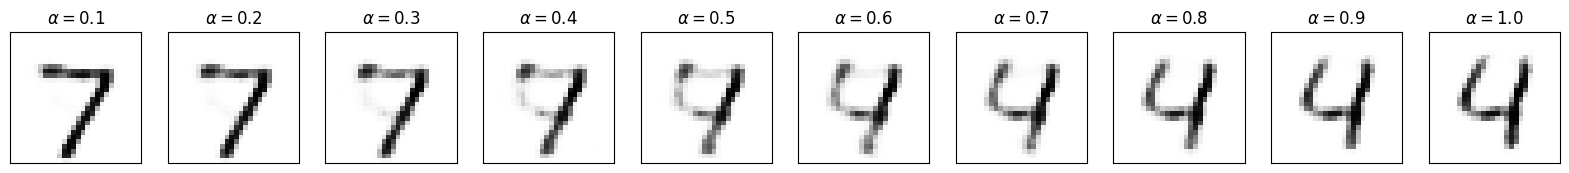

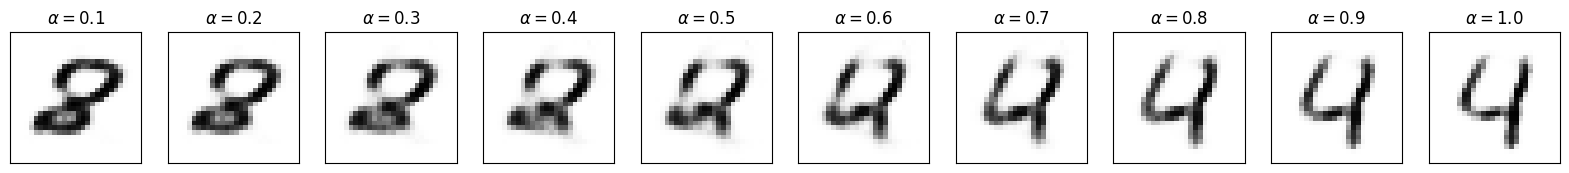

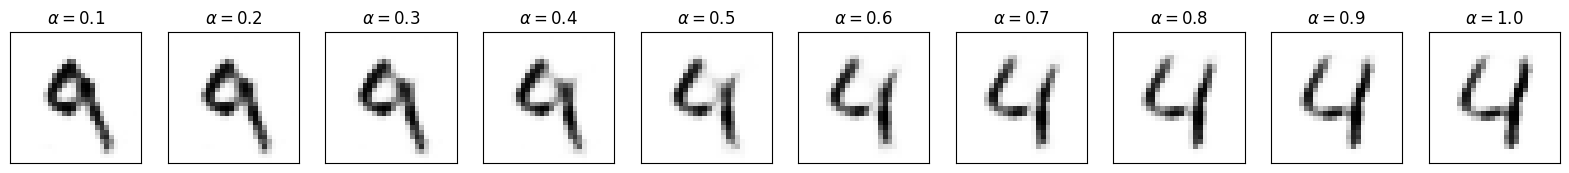

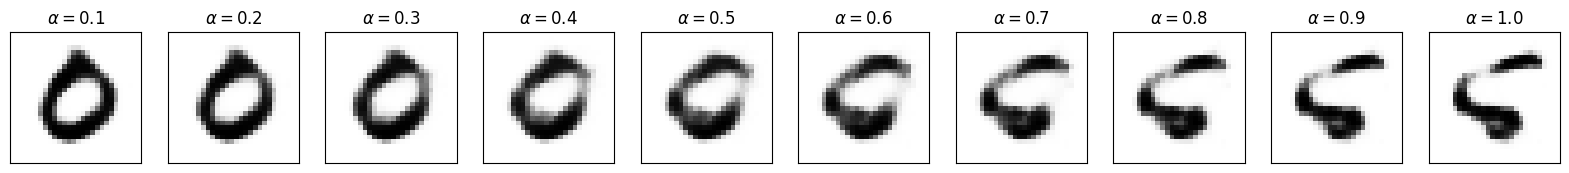

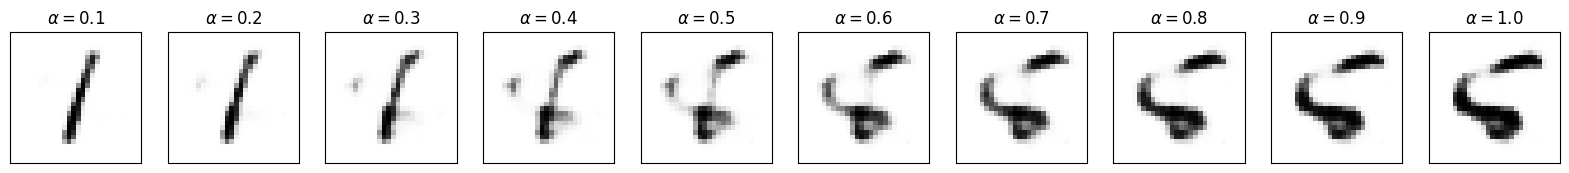

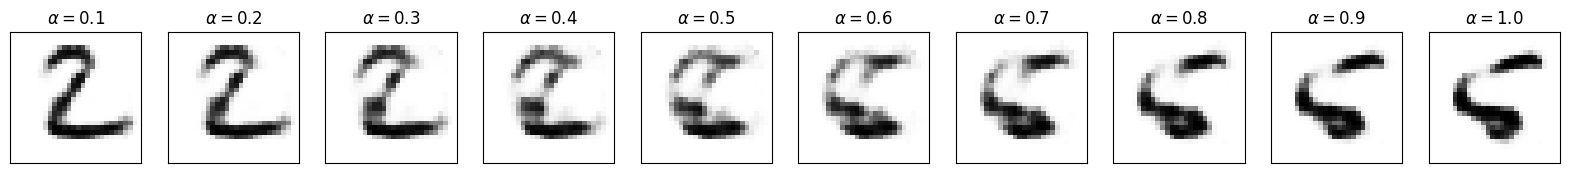

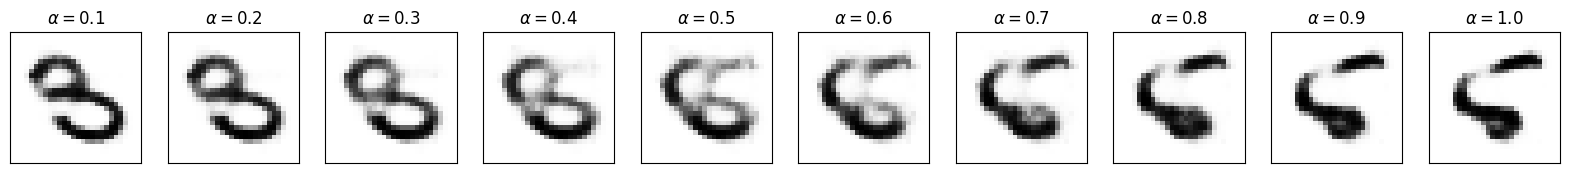

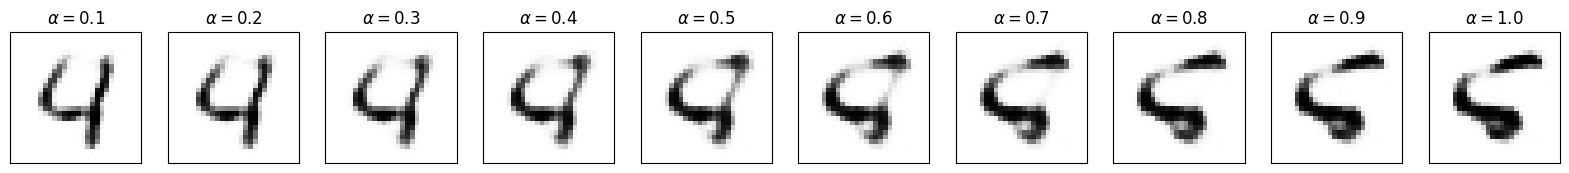

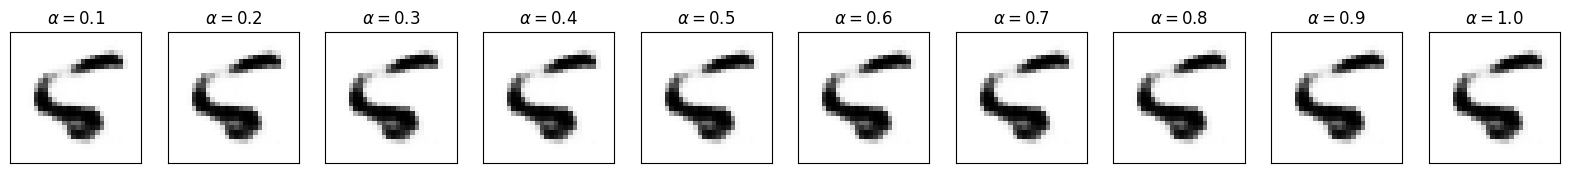

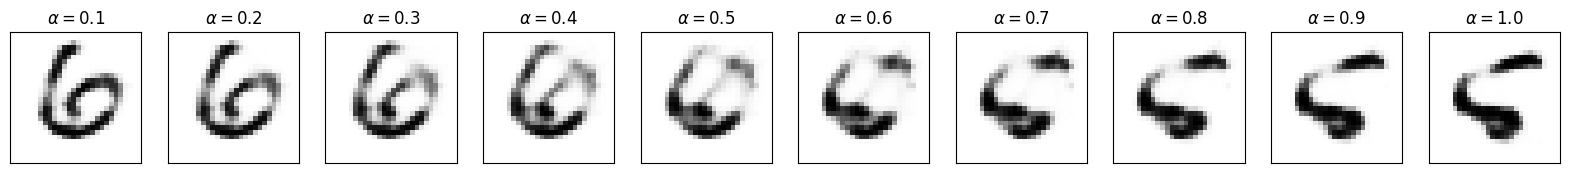

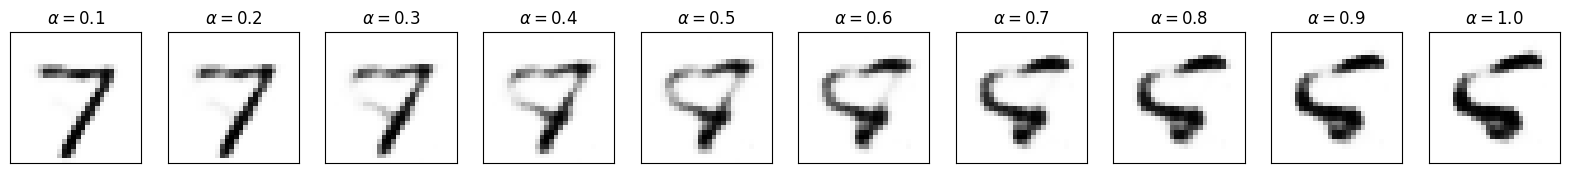

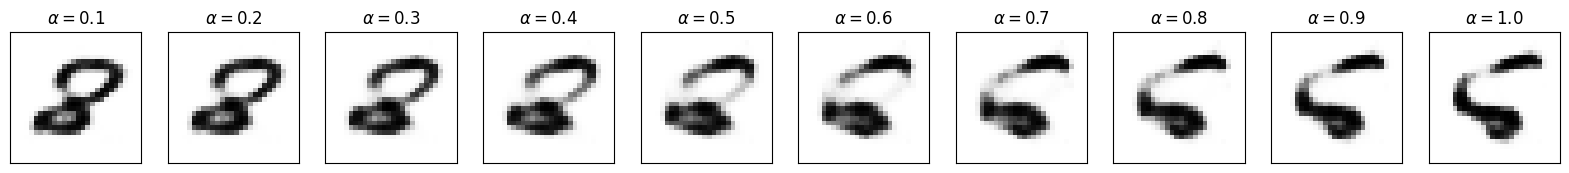

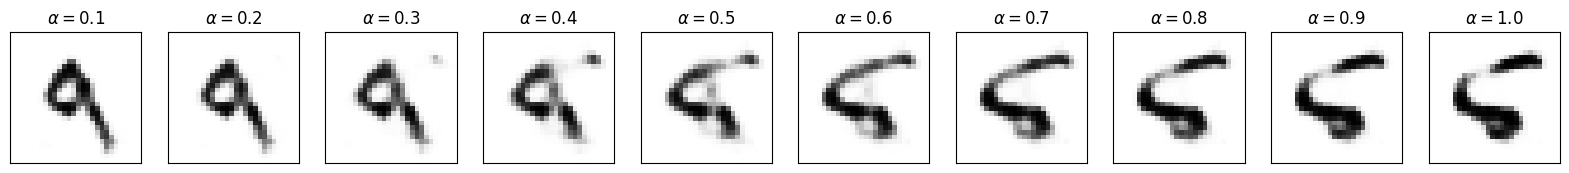

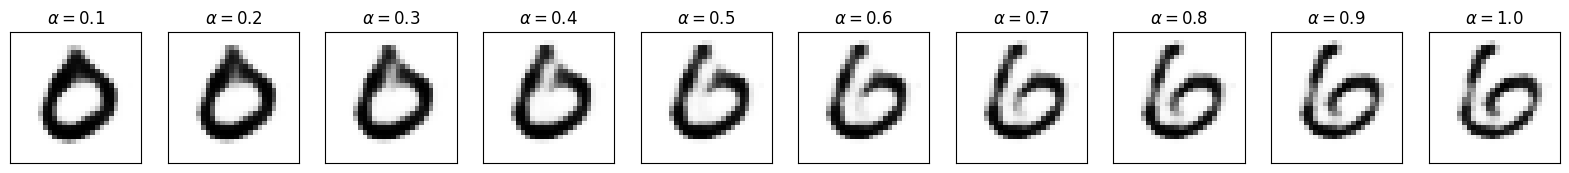

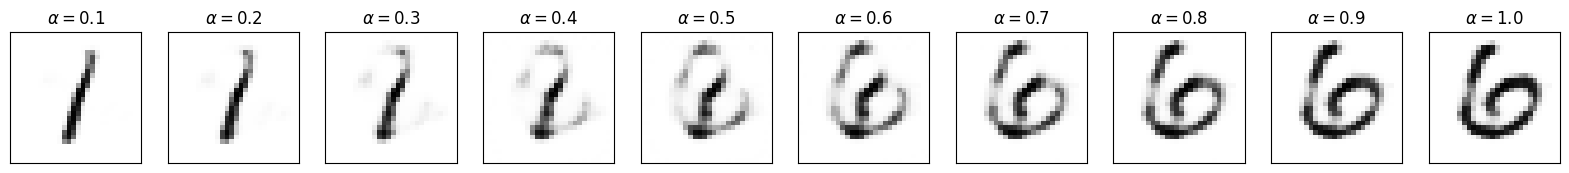

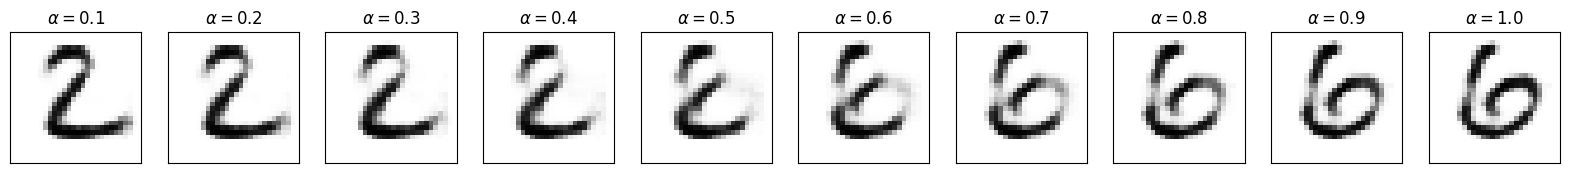

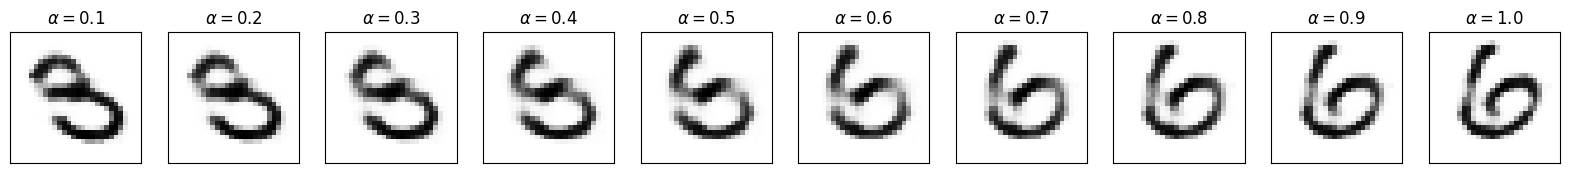

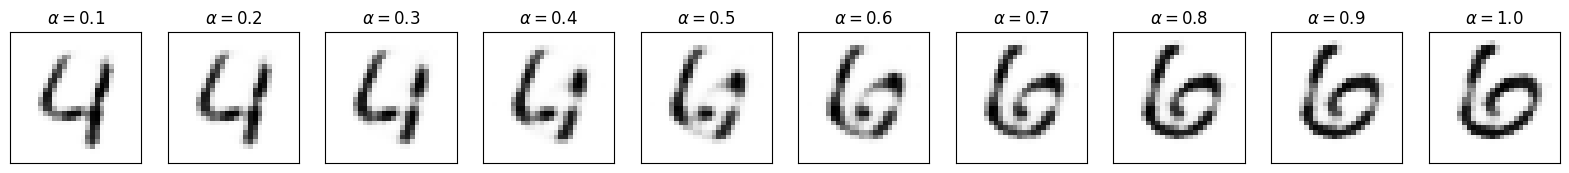

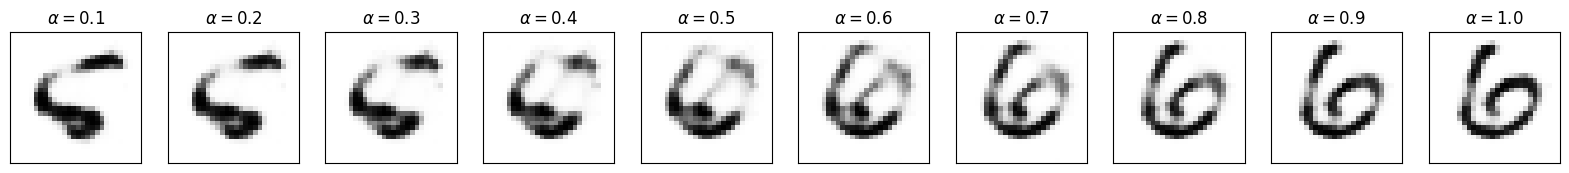

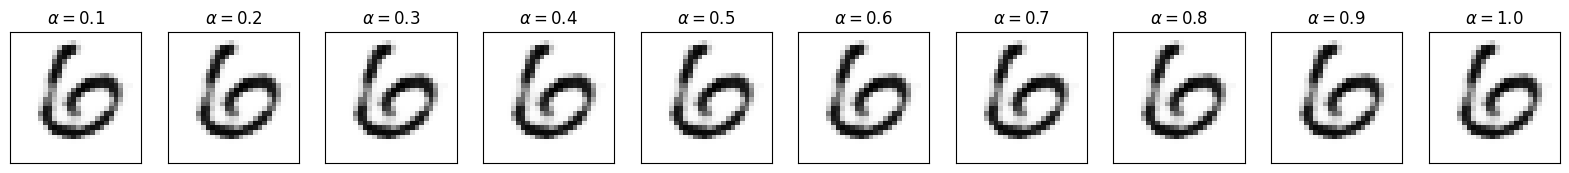

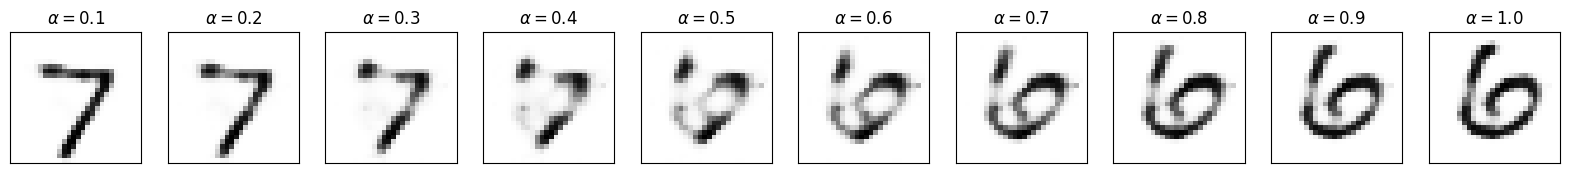

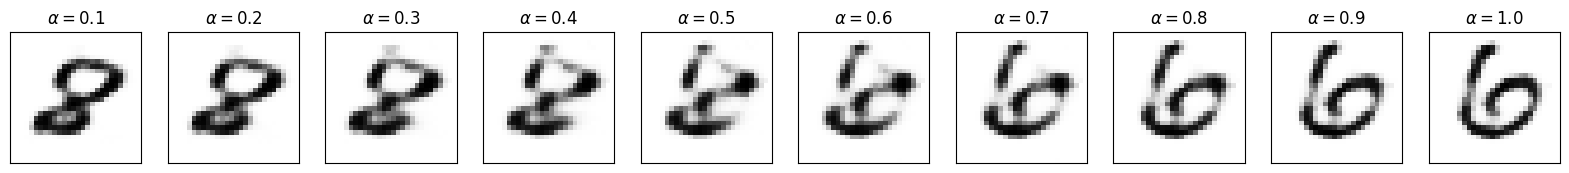

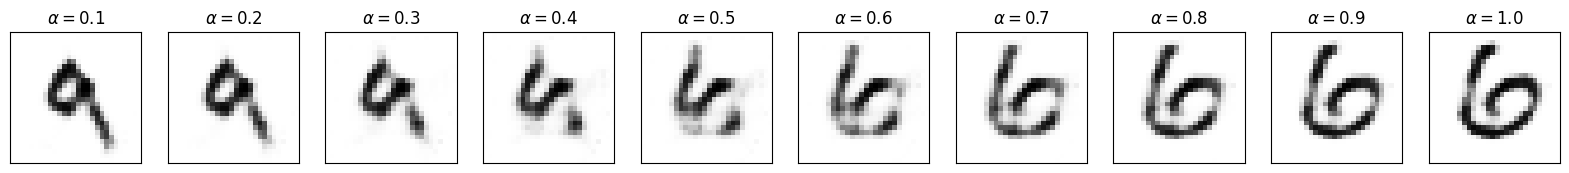

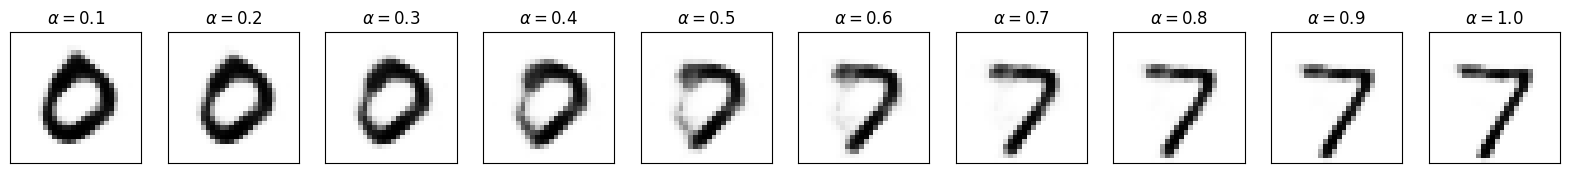

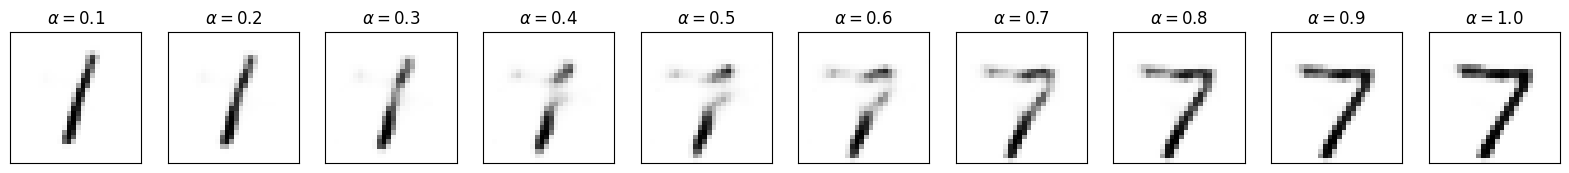

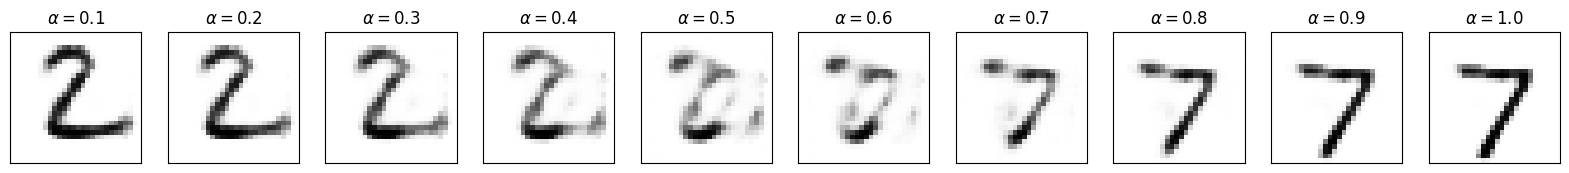

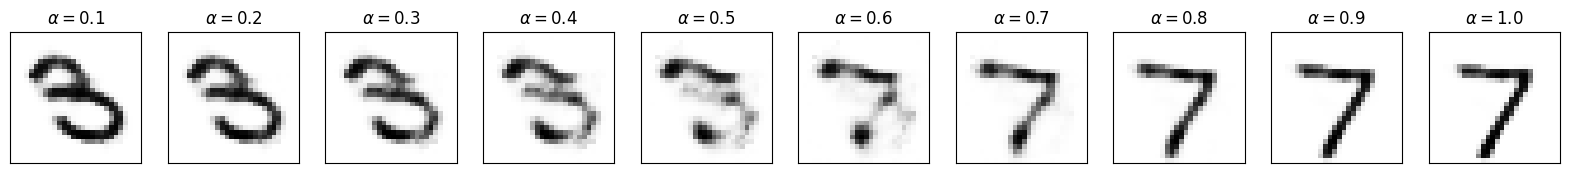

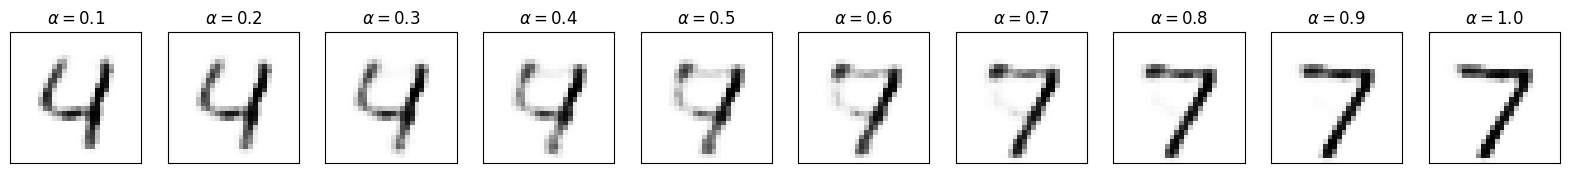

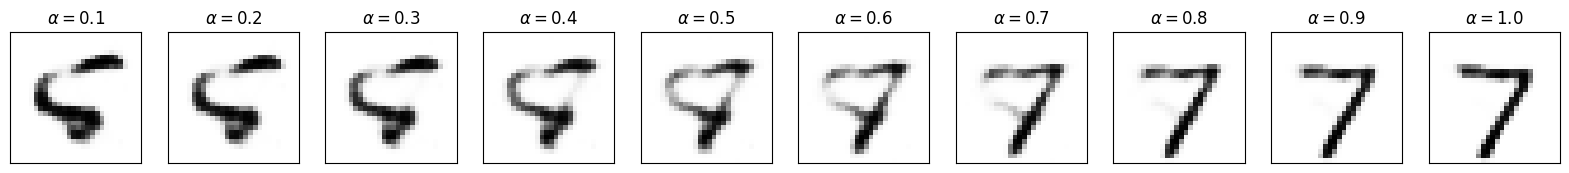

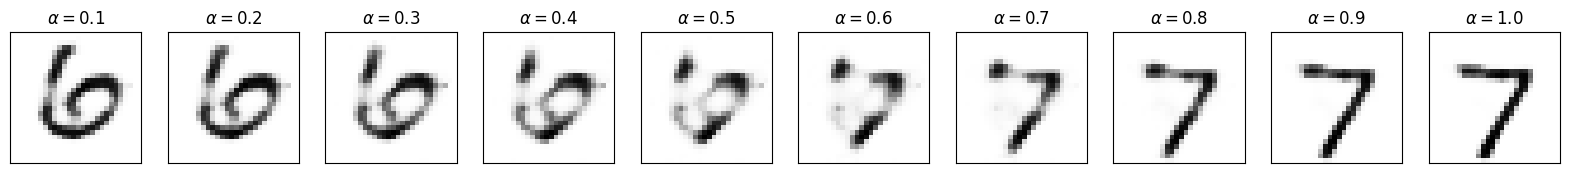

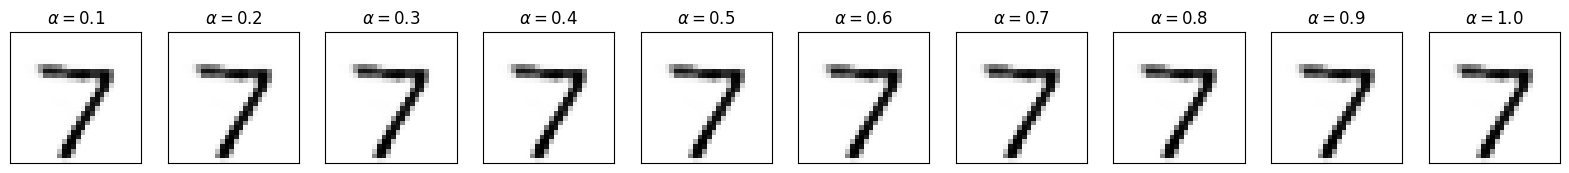

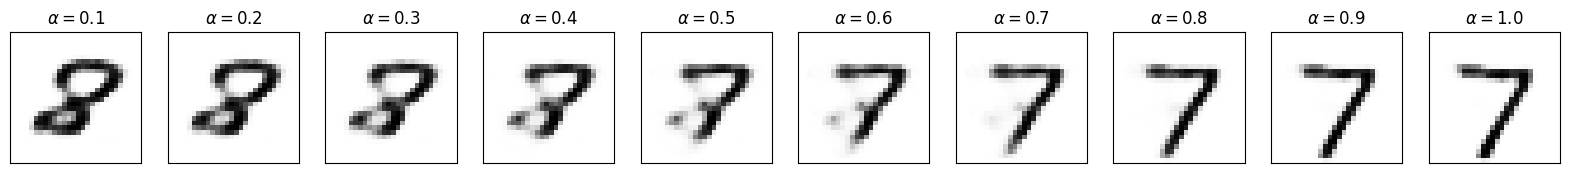

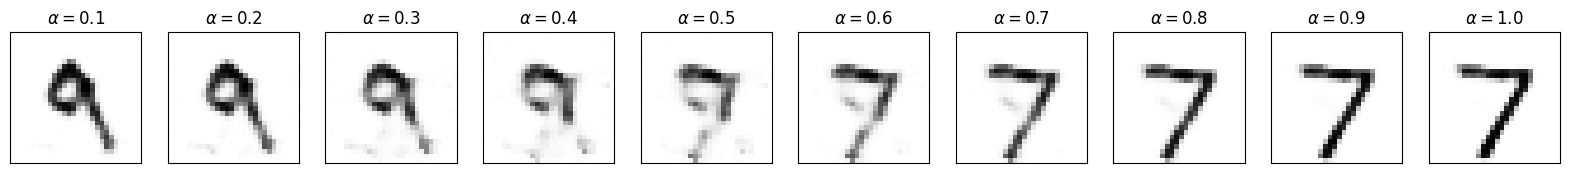

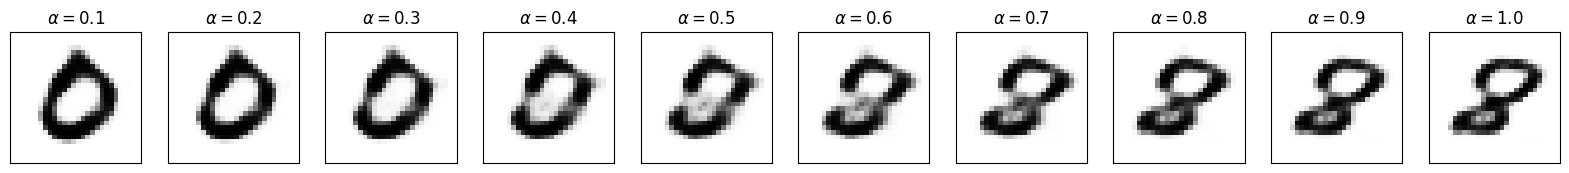

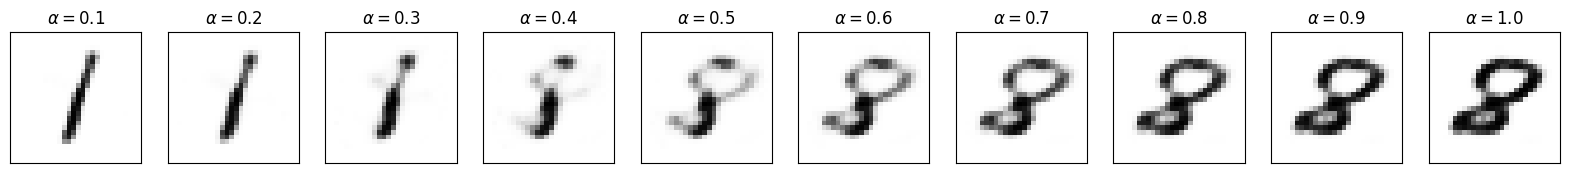

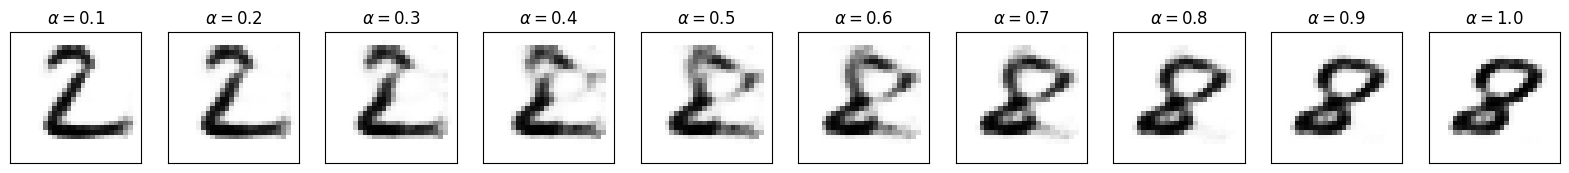

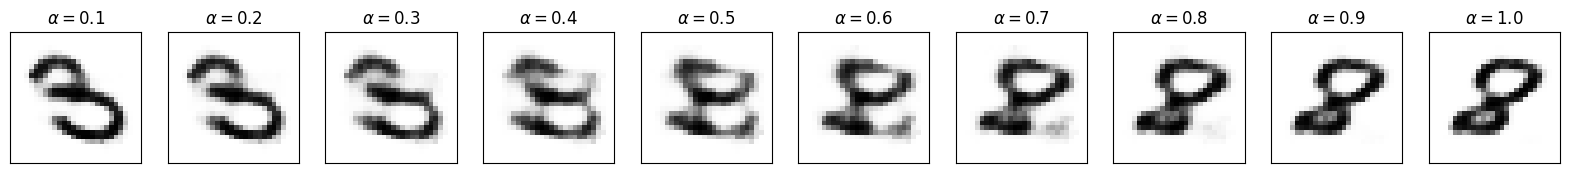

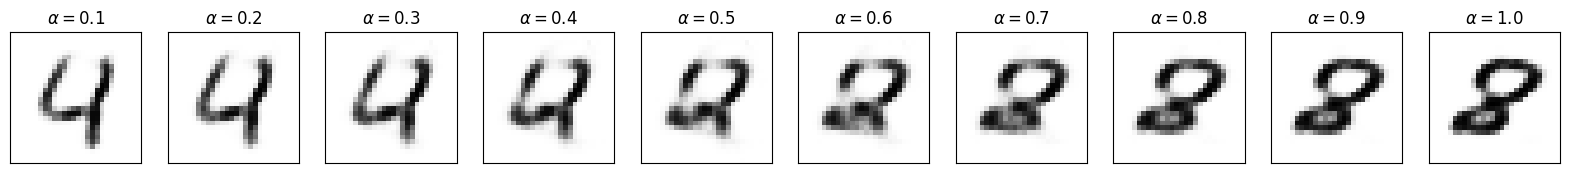

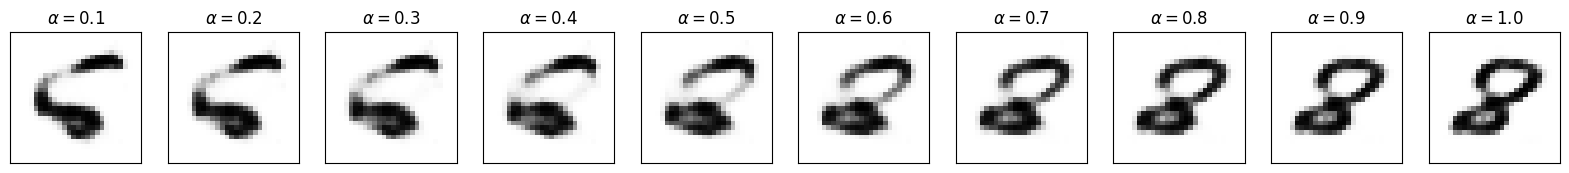

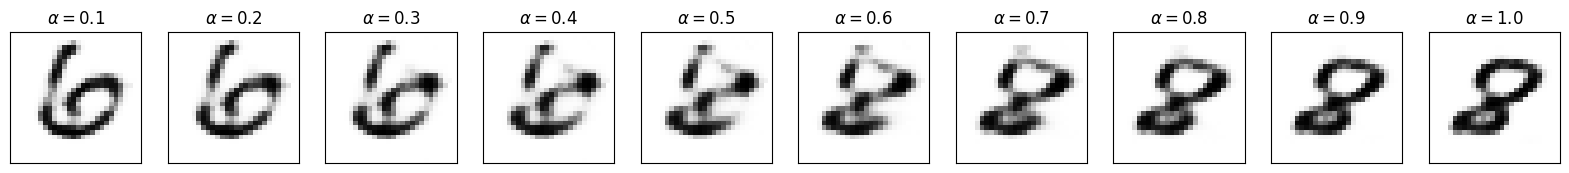

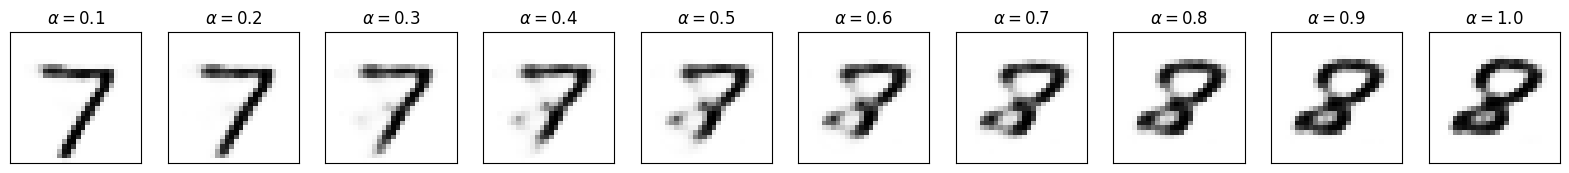

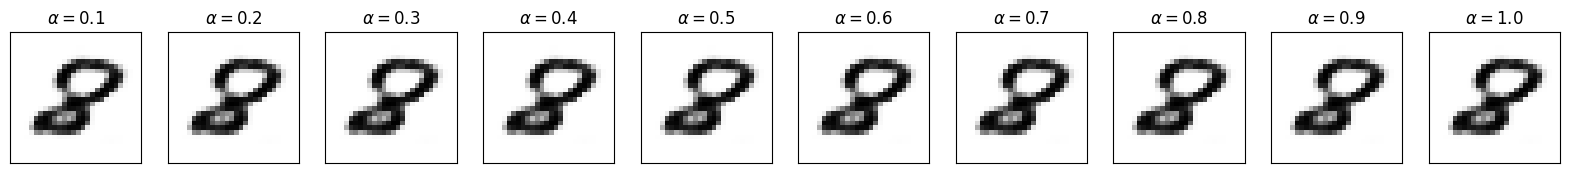

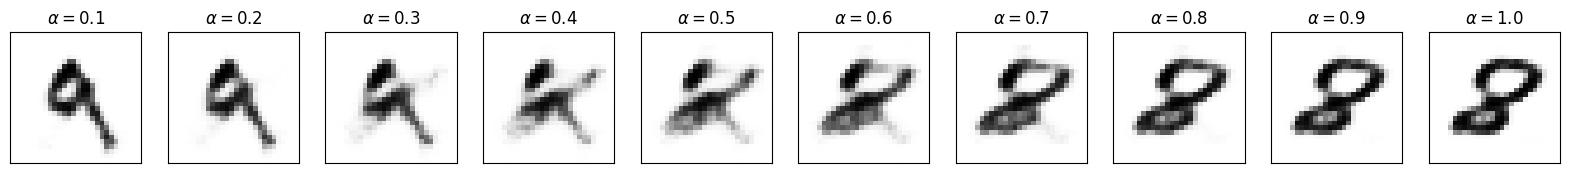

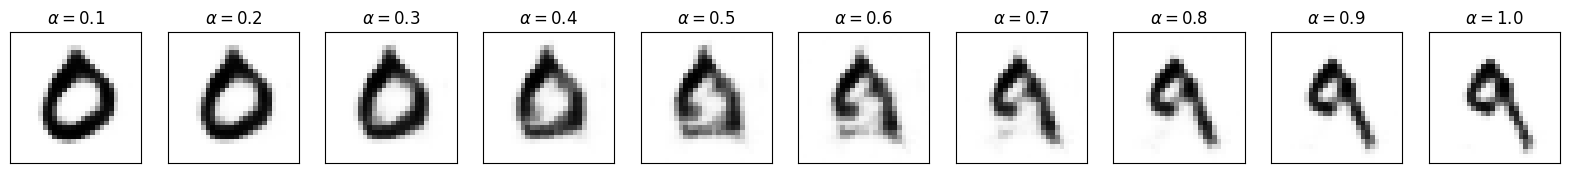

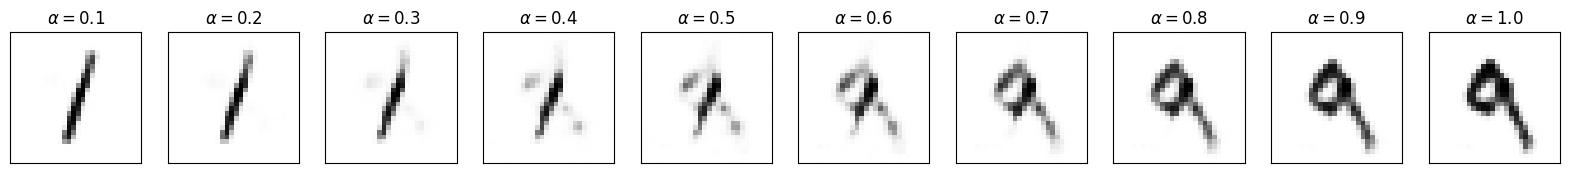

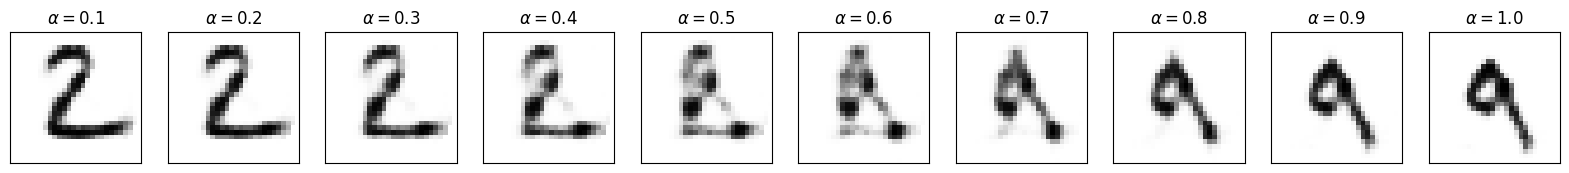

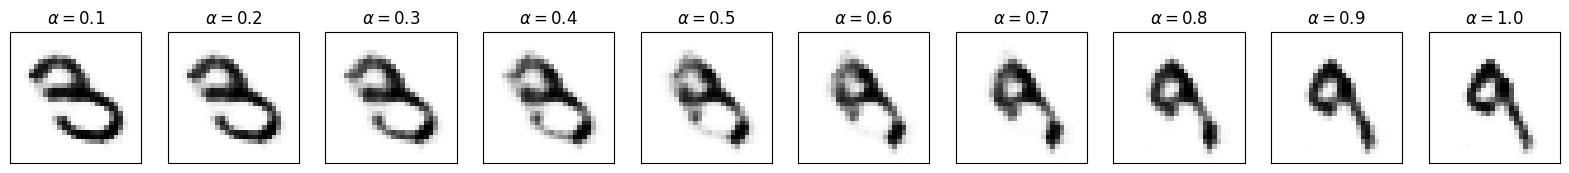

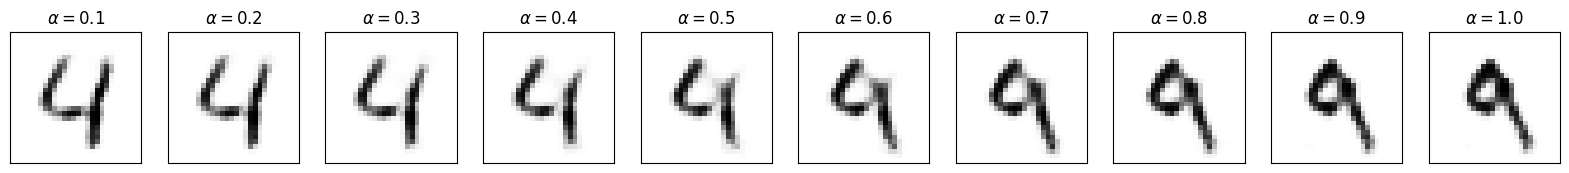

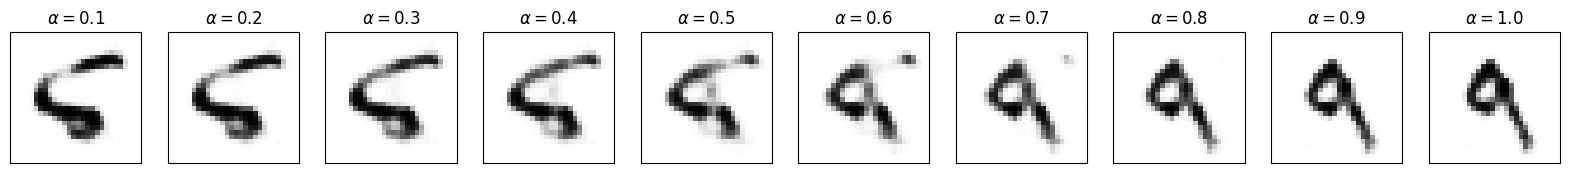

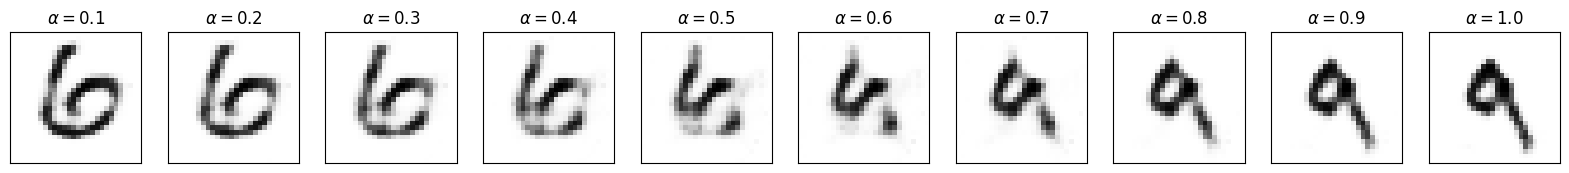

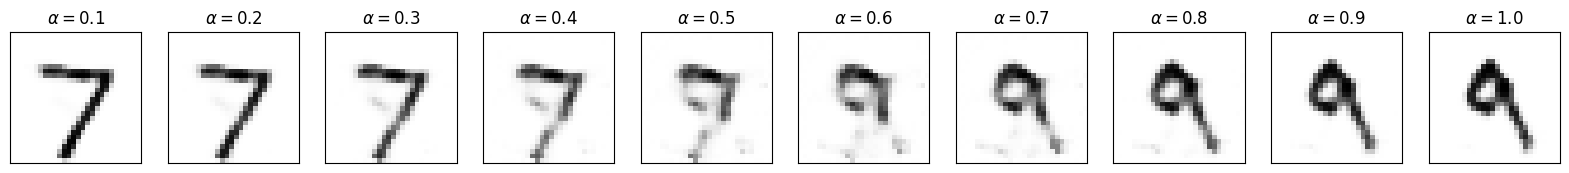

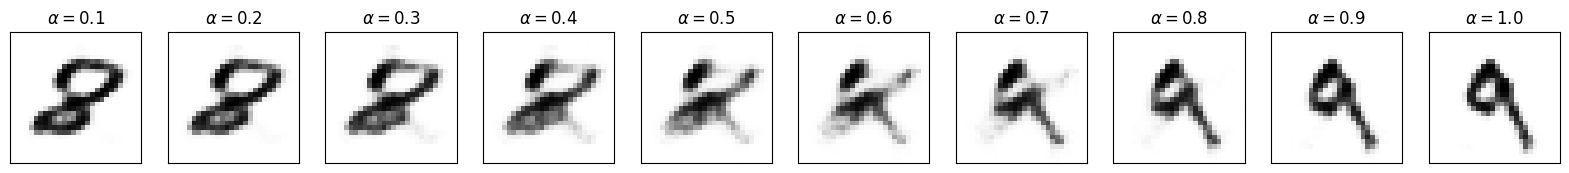

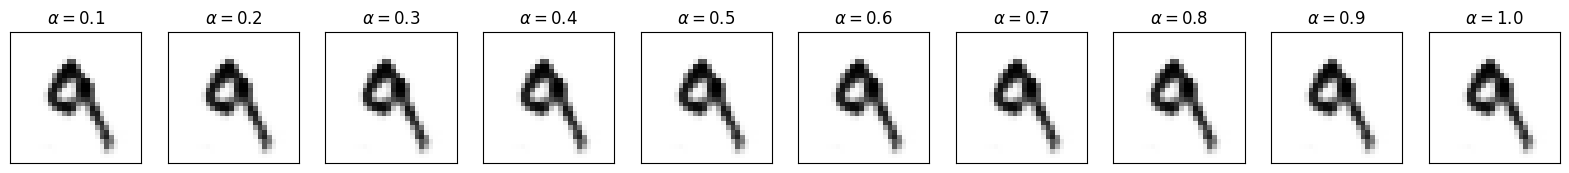

In [210]:
test_interpolation_multiple_alpha_different_class(deep_dae, test_data, test_label)

## Comments